# Calibrate the holograms using Halpha filter
==================================================================================================

- author : Jérémy Neveu
- date   : May 31st 2017


In [1]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

print theNotebook
from IPython.display import Image, display
import sys
sys.path.append("../../common_tools/")
from common_notebook import *

init_notebook()

FullAnalysis
ccdproc version 1.2.0
bottleneck version 1.2.0
/Users/jneveu/Documents/LSST/Calibration/CTIOAnaJun2017/ana_31may17/FocusHalpha


### Input directory

In [3]:
#inputdir="../OverScanRemove/trim_images"
inputdir="../../data/CTIODataJune2017_reducedRed/data_31may17/"
MIN_IMGNUMBER=51
MAX_IMGNUMBER=55
date = "20170531"
tag = "reduc"
object_name='HD111980'
SelectTagRe='^%s_%s_([0-9]+).fits$' % (tag,date) # regular expression to select the file
SearchTagRe='^%s_%s_[0-9]+.fits$' % (tag,date)
NBIMGPERROW=2

### Output directories

In [4]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images
ensure_dir(dir_top_images) # create that directory

outputdir="./cut_fitsimages"
ensure_dir(outputdir)

## Location of the spectra
----------------------------------

In [5]:
dirlist_all = [inputdir]
sorted_numbers,sorted_files = MakeFileList(dirlist_all,MIN_IMGNUMBER,MAX_IMGNUMBER,SelectTagRe,SearchTagRe) 

all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

print 'Number of images:',len(all_images)

Number of images: 5


### Show images

Processing image 0...
Processing image 1...
Processing image 2...
Processing image 3...
Processing image 4...


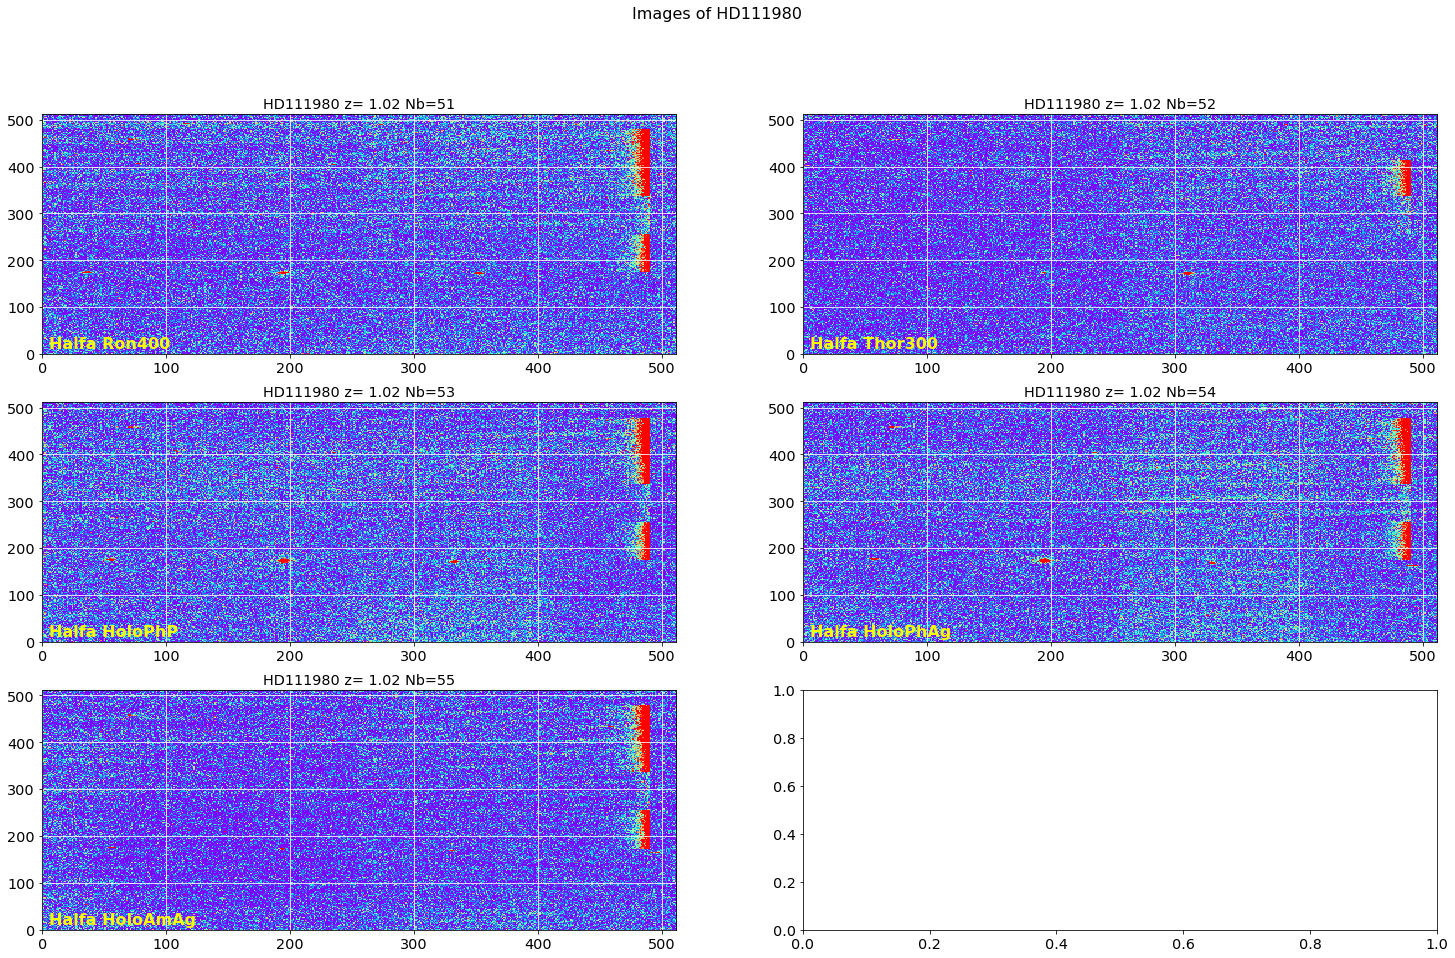

In [6]:
ShowImages(all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=20,downsampling=4,verbose=True)

figfilename=os.path.join(dir_top_images,'input_images.pdf')
plt.savefig(figfilename)   

### Show histograms

Processing image 0...
Processing image 1...
Processing image 2...
Processing image 3...
Processing image 4...


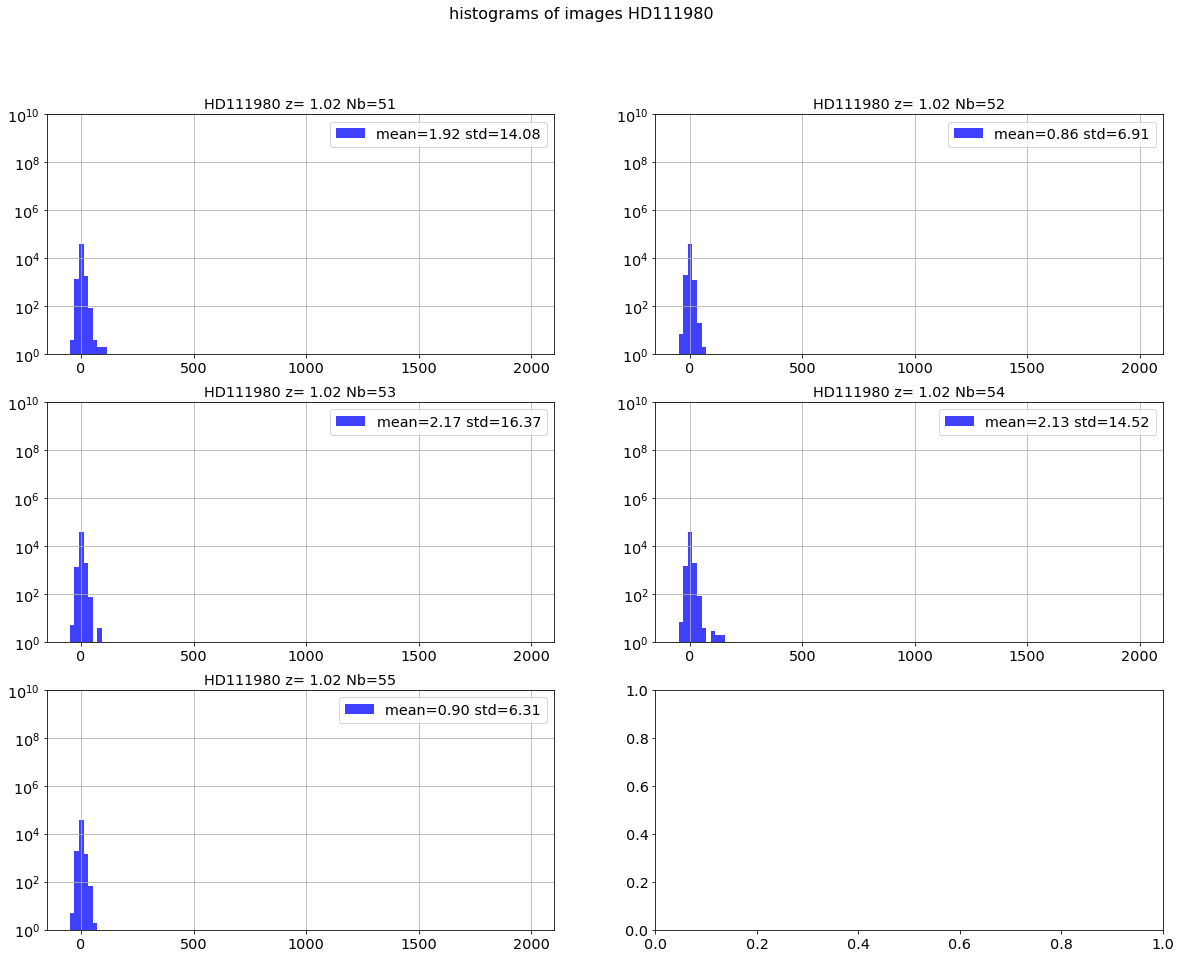

In [9]:
ShowHistograms(all_images,all_titles,all_filt,object_name,
               NBIMGPERROW=2,bins=100,range=(-50,2000),downsampling=10,verbose=True)

### Cut the images

To extract the spectra to analyze

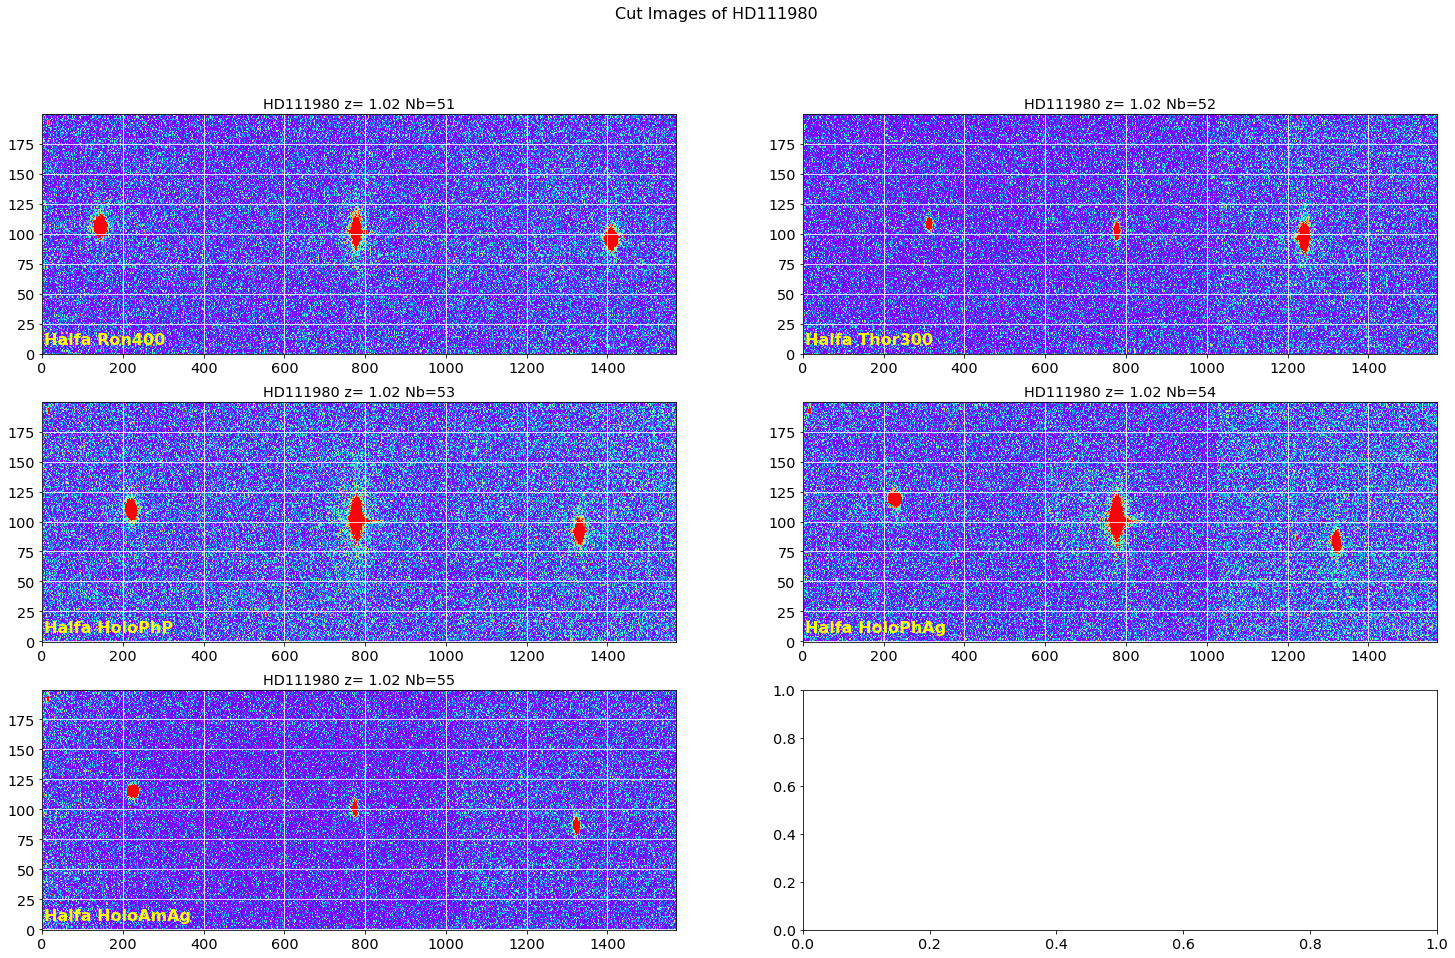

In [10]:
x_guess = [770]*len(all_images)
y_guess = [690]*len(all_images)
DeltaY=[100]*len(all_images)
DeltaX=[800]*len(all_images)

images_cut=ShowCenterImages(x_guess,y_guess,DeltaX,DeltaY,all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=20)
figfilename=os.path.join(dir_top_images,'cut_images.pdf')
plt.savefig(figfilename)   

### Save cut images

In [11]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[-1]
    print short_infilename
    short_partfilename=re.findall('^%s_(.*)' % tag,short_infilename)
    short_outfilename='cutimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)
    
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,overwrite=True)

reduc_20170531_051.fits
reduc_20170531_052.fits
reduc_20170531_053.fits
reduc_20170531_054.fits
reduc_20170531_055.fits


In [12]:
!ls -l cut_fitsimages/*

-rw-r--r--  1 jneveu  staff  2525760  8 aoû 14:29 cut_fitsimages/cutimg_20170531_051.fits
-rw-r--r--  1 jneveu  staff  2525760  8 aoû 14:29 cut_fitsimages/cutimg_20170531_052.fits
-rw-r--r--  1 jneveu  staff  2525760  8 aoû 14:29 cut_fitsimages/cutimg_20170531_053.fits
-rw-r--r--  1 jneveu  staff  2525760  8 aoû 14:29 cut_fitsimages/cutimg_20170531_054.fits
-rw-r--r--  1 jneveu  staff  2525760  8 aoû 14:29 cut_fitsimages/cutimg_20170531_055.fits
-rw-r--r--  1 jneveu  staff       56 26 jul 13:14 cut_fitsimages/star_centroids.txt


# Find the optimal rotation of the spectra
============================

In [13]:
inputdir="./cut_fitsimages"
SelectTagRe='^cutimg_%s_([0-9]+).fits$' % date # regular expression to select the file
SearchTagRe='^cutimg_%s_[0-9]+.fits$' % date

outputdir="./rotated_fitsimages"
ensure_dir(outputdir)

In [14]:
sorted_numbers,sorted_files = MakeFileList([inputdir],MIN_IMGNUMBER,MAX_IMGNUMBER,SelectTagRe,SearchTagRe) 

all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

print 'Number of images:',len(all_images)

Number of images: 5


## Find rotation by Hessian analysis

La méthode s'inspire des techniques de détection de filmanents dans le milieu interstellaire.
Elle est décrite dans https://arxiv.org/pdf/1409.6728.pdf section 4.1.
Documentation sur le calcul du Hessien : http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hessian_matrix

### Test rotation optimal settings

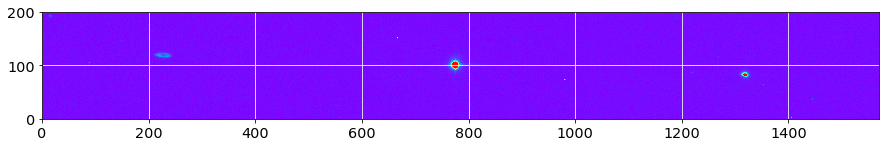

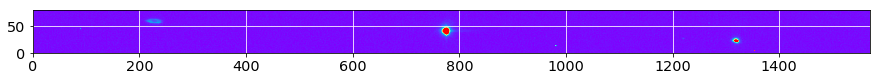

In [15]:
sel=3
image_sel=np.copy(all_images[sel])
y0=DeltaY[sel]
x0=x_guess[sel]

width_cut = 40
right_edge = 1600

plt.imshow(image_sel,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')
plt.show()

region=np.copy(image_sel[y0-width_cut:y0+width_cut,0:right_edge])
data=np.copy(region)
plt.imshow(data,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')
plt.show()

In [16]:
# le paramètre sigma permet de lisser le hessien
Hxx, Hxy, Hyy = hessian_matrix(data, sigma=3, order = 'xy')
lambda_plus = 0.5*( (Hxx+Hyy) + np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
lambda_minus = 0.5*( (Hxx+Hyy) - np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
theta = 0.5*np.arctan2(2*Hxy,Hyy-Hxx)*180/np.pi

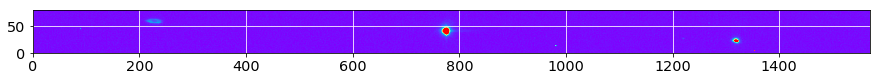

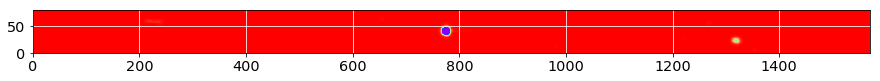

In [17]:
plt.imshow(data,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')
plt.show()
plt.imshow(lambda_minus,origin='lower',cmap='rainbow',vmin=-100,vmax=0)
plt.grid(color='white', ls='solid')
plt.show()

Number of remaining pixels : 694


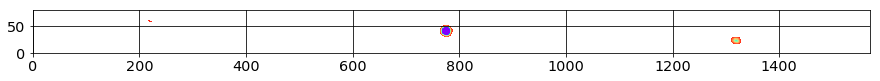

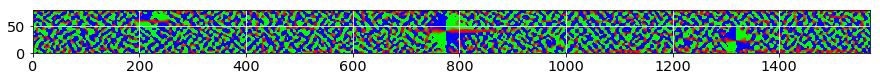

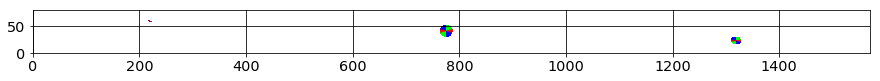

In [18]:
lambda_threshold = -5
margin_cut = 1

lambda_minus = lambda_minus[margin_cut:-margin_cut,margin_cut:-margin_cut]
lambda_plus = lambda_plus[margin_cut:-margin_cut,margin_cut:-margin_cut]
theta = theta[margin_cut:-margin_cut,margin_cut:-margin_cut]

mask = np.where(lambda_minus>lambda_threshold)
lambda_mask = np.copy(lambda_minus)
lambda_mask[mask]=np.nan

theta_mask = np.copy(theta)
theta_mask[mask]=np.nan

print 'Number of remaining pixels :',len(lambda_mask[~np.isnan(lambda_mask)])

plt.imshow(lambda_mask,origin='lower',cmap='rainbow',vmin=-100,vmax=0)
plt.grid(color='black', ls='solid')
plt.show()

plt.imshow(theta,origin='lower',cmap=cm.brg,vmin=-30,vmax=30)
plt.grid(color='white', ls='solid')
plt.show()

plt.imshow(theta_mask,origin='lower',cmap=cm.brg,vmin=-30,vmax=30)
plt.grid(color='black', ls='solid')
plt.show()

Number of remaining pixels : 175


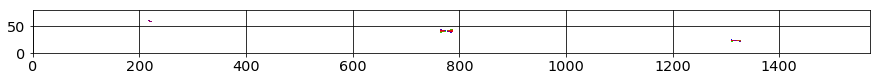

In [19]:
deg_threshold = 20

mask2 = np.where(np.abs(theta)>deg_threshold)
theta_mask[mask2] = np.nan
print 'Number of remaining pixels :',len(theta_mask[~np.isnan(theta_mask)])
plt.imshow(theta_mask,origin='lower',cmap=cm.brg,vmin=-deg_threshold,vmax=deg_threshold)
plt.grid(color='black', ls='solid')
plt.show()

Angle median : -3.20707688983


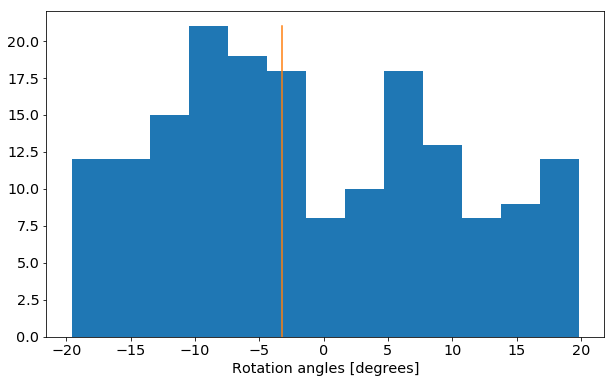

In [20]:
theta_hist = []
theta_hist = theta_mask[~np.isnan(theta_mask)].flatten()
theta_median = np.median(theta_hist)
print 'Angle median :',theta_median
fig = plt.figure(figsize=(10,6))
n,bins, patches = plt.hist(theta_hist,bins=int(np.sqrt(len(theta_hist))))
plt.plot([theta_median,theta_median],[0,np.max(n)])
plt.xlabel("Rotation angles [degrees]")
plt.show()

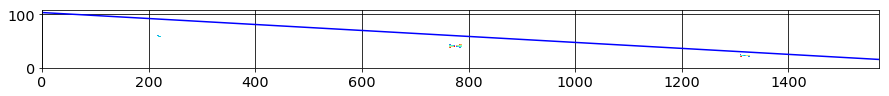

In [21]:
xindex=np.arange(data.shape[1])
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = y0 - width_cut + (x_new-x0)*np.tan(theta_median*np.pi/180.)
plt.imshow(theta_mask,origin='lower',cmap='rainbow',vmin=-deg_threshold,vmax=deg_threshold)
plt.plot(x_new,y_new,'b-')
plt.grid(color='black', ls='solid')
plt.show()

On peut aussi essayer de fitter le spectre qui a été détecté par la méthode ci-dessus.

Rotation angle from fit : -1.89545500644


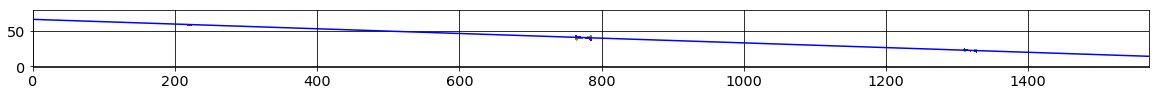

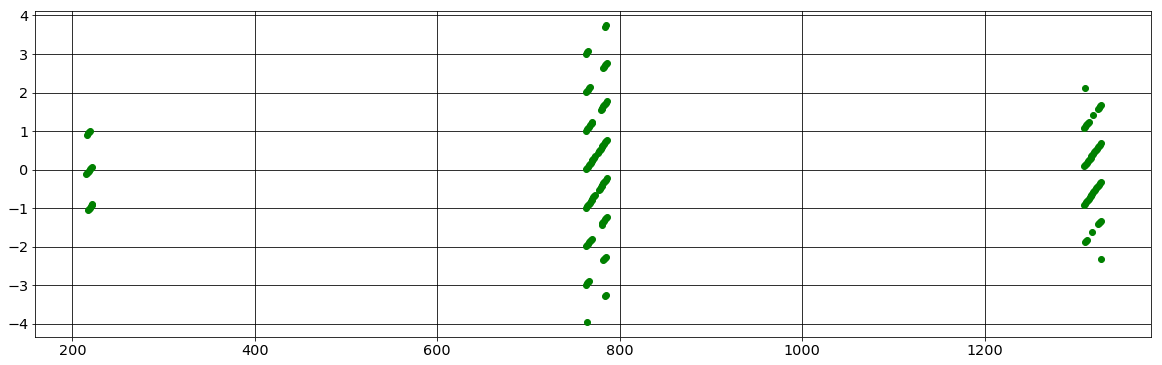

In [22]:
xtofit=[]
ytofit=[]
for iy,y in enumerate(theta_mask):
    for ix,x in enumerate(y):
        if not np.isnan(theta_mask[iy][ix]) :
            if np.abs(theta_mask[iy][ix])>deg_threshold : continue
            xtofit.append(ix)
            ytofit.append(iy)
popt, pcov = fit_line(xtofit, ytofit)
[a, b] = popt
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = line(x_new,a,b)
print 'Rotation angle from fit :',np.arctan(a)*180/np.pi
fig = plt.figure(figsize=[20,6])
plt.imshow(theta_mask,origin='lower',cmap=cm.brg,vmin=-deg_threshold,vmax=deg_threshold)
plt.plot(x_new,y_new,'b-')
plt.grid(color='black', ls='solid')
plt.show()
fig = plt.figure(figsize=[20,6])
diff = []
for ix,x in enumerate(xtofit):
    diff.append(ytofit[ix]-line(x,a,b))
plt.plot(xtofit,diff,'go')
plt.grid(color='black', ls='solid')
plt.show()

0  theta =  -0.465835792603
1  theta =  -0.747490328563
2  theta =  -0.929739997597
3  theta =  -1.89545500644
4  theta =  -1.49709850749


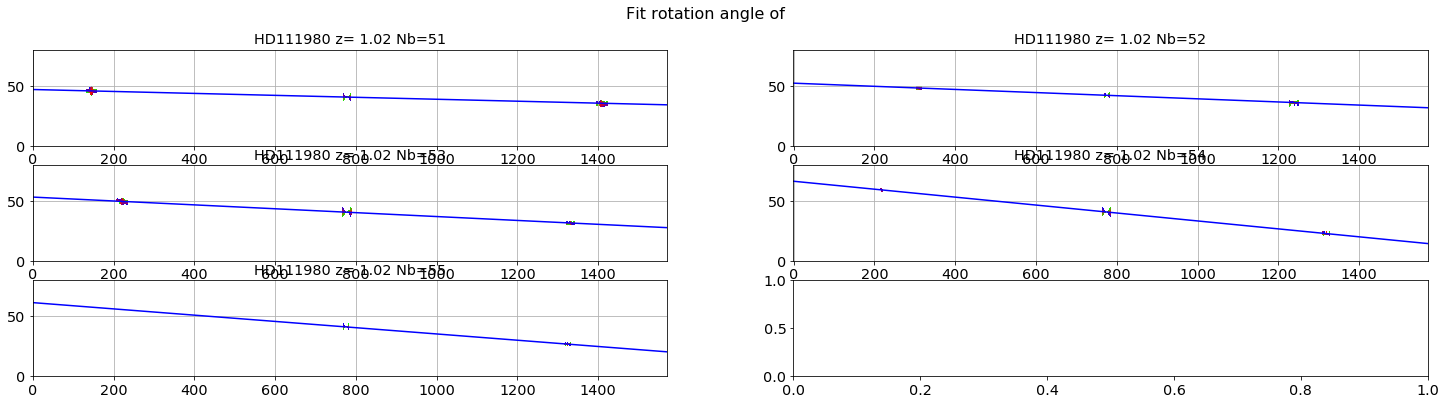

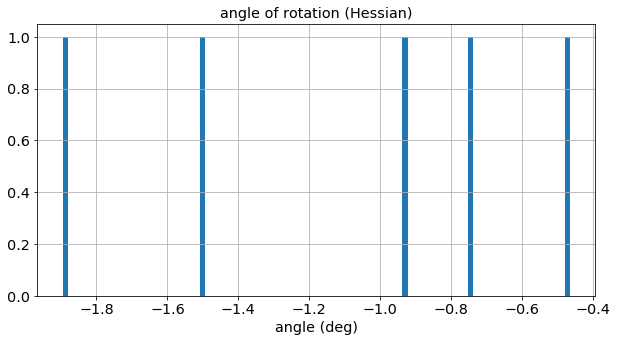

In [23]:
all_theta=ComputeRotationAngleHessianAndFit(all_images,x_guess,DeltaY,all_titles,object_name, 
            NBIMGPERROW=2, lambda_threshold = -5, deg_threshold = 20, width_cut = 40, right_edge = 1600)
figfilename=os.path.join(dir_top_images,'fit_rotation.pdf')
plt.savefig(figfilename)  

for index in range(len(all_theta)):
    print index,' theta = ',all_theta[index]
plt.figure(figsize=(10,5))
n, bins, patches=plt.hist(all_theta,bins=100,histtype='stepfilled')
plt.grid(True)
plt.title('angle of rotation (Hessian)')
plt.xlabel('angle (deg)')

### Turn the images accordingly

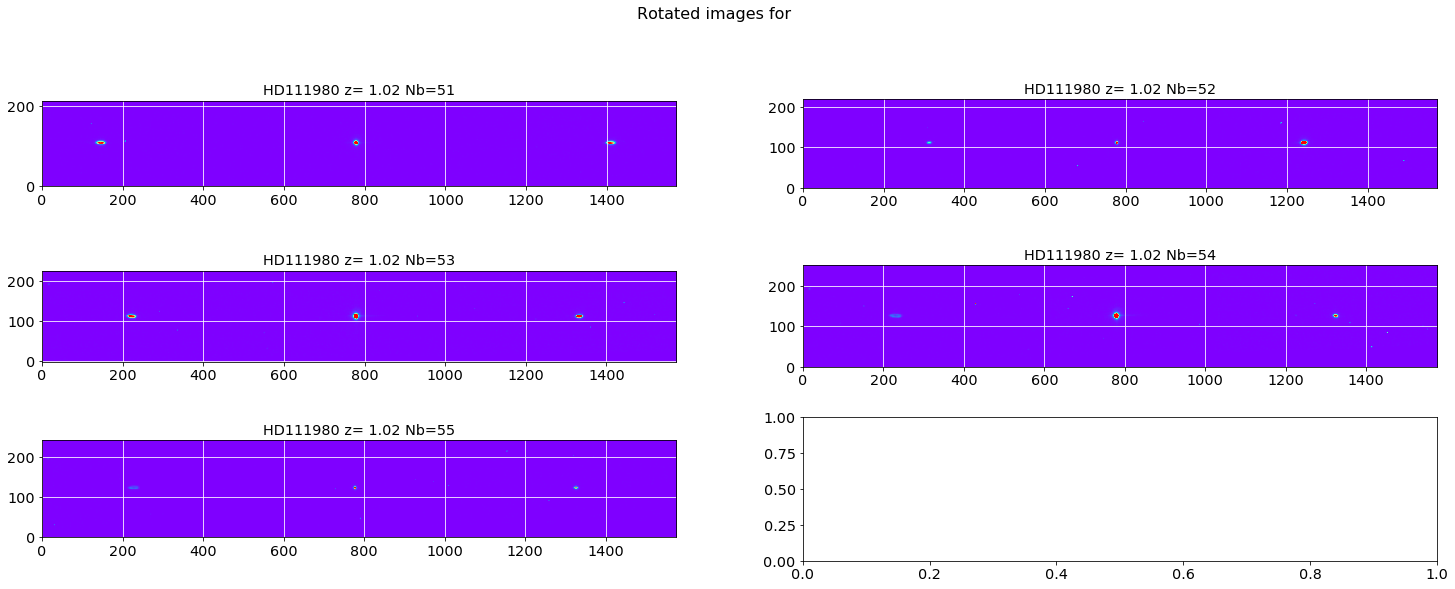

In [24]:
turned_images=TurnTheImages(all_images,all_theta,all_titles,object_name,NBIMGPERROW=2,
                            oversample_factor=1) 
figfilename=os.path.join(dir_top_images,'rotated_images.pdf')
plt.savefig(figfilename)  

### Check rotation

In case of bad rotation, check by eye

array([-0.01123225, -0.16571498, -0.00056922,  0.0011008 ,  0.00291305])

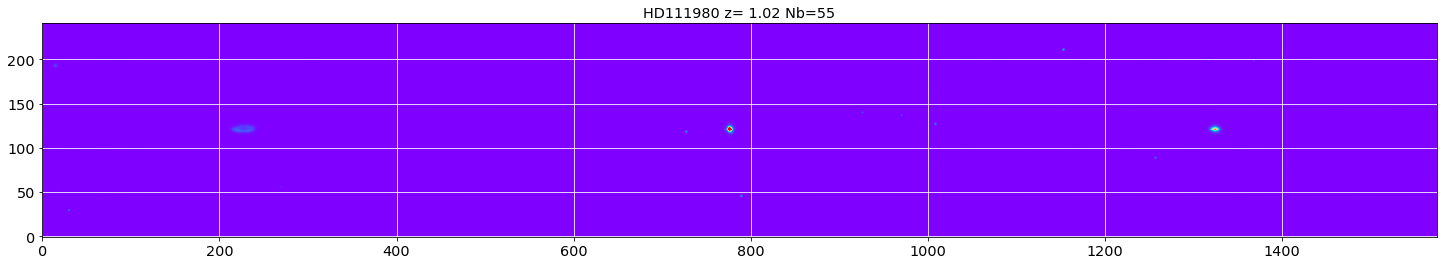

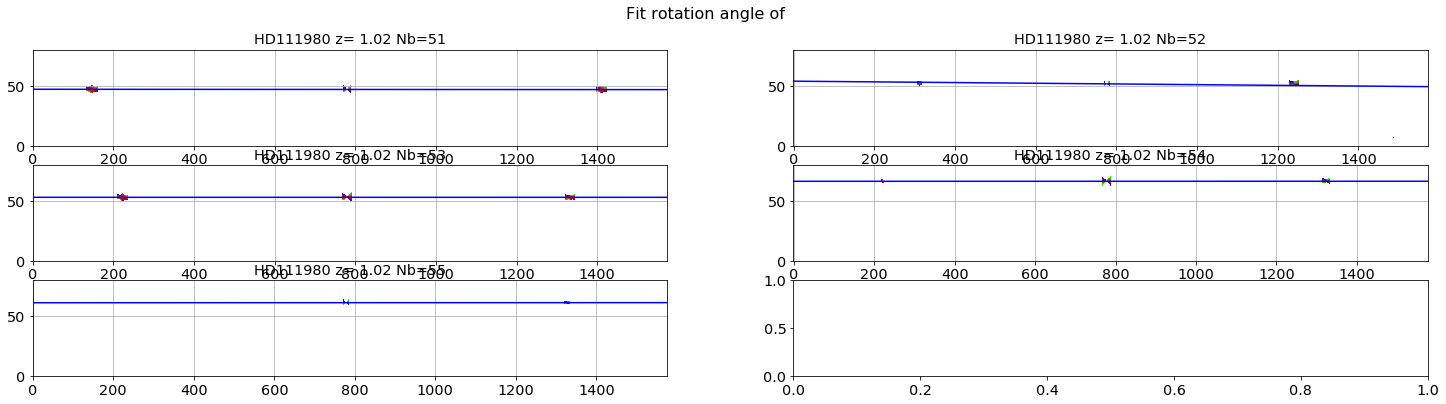

In [25]:
sel=4
plt.figure(figsize=(25,10))
plt.imshow(turned_images[sel],origin='lower',cmap='rainbow',vmin=0,vmax=1000)
plt.grid(True)
plt.title(all_titles[sel])
plt.grid(color='white', ls='solid')
figfilename=os.path.join(dir_top_images,'rotated_image_sample.pdf')
plt.savefig(figfilename)  

ComputeRotationAngleHessianAndFit(turned_images,x_guess,DeltaY,all_titles,object_name, 
            NBIMGPERROW=2, lambda_threshold = -5, deg_threshold = 20, width_cut = 40, right_edge = 1600)

Cut the extra spectra that pollute the images.

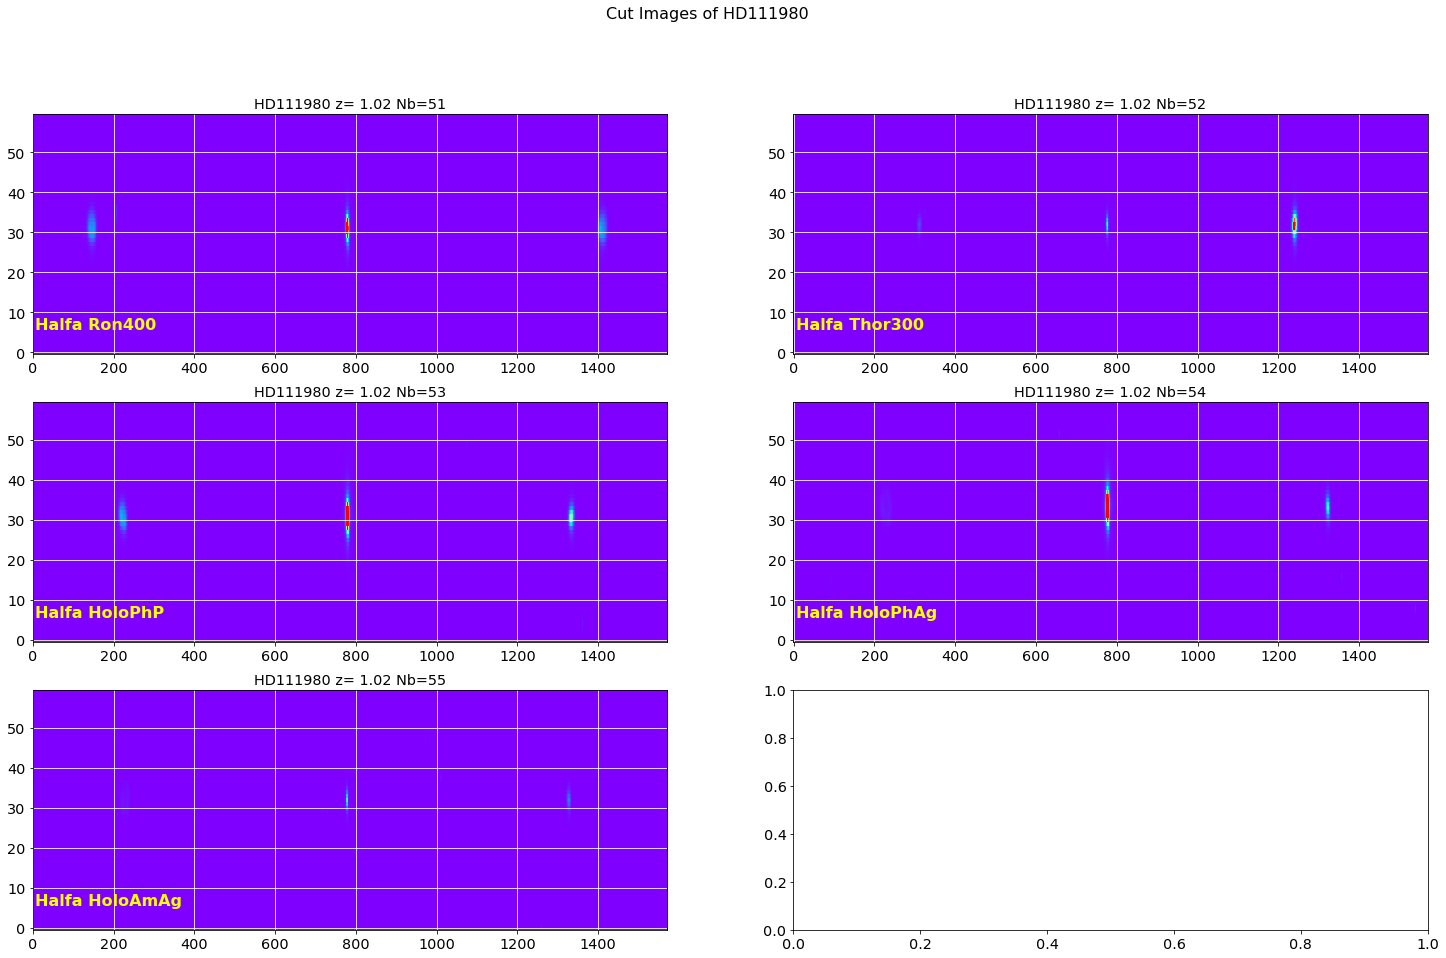

In [27]:
DeltaY_rot2 = [30]*len(all_images)
y_guess_rot2 = [106,110,112,123,119]
images_cut_rot=ShowCenterImages(x_guess,y_guess_rot2,DeltaX,DeltaY_rot2,
                    turned_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=5000) 

# Find the central star locations
======================================

### Central star positions after rotation

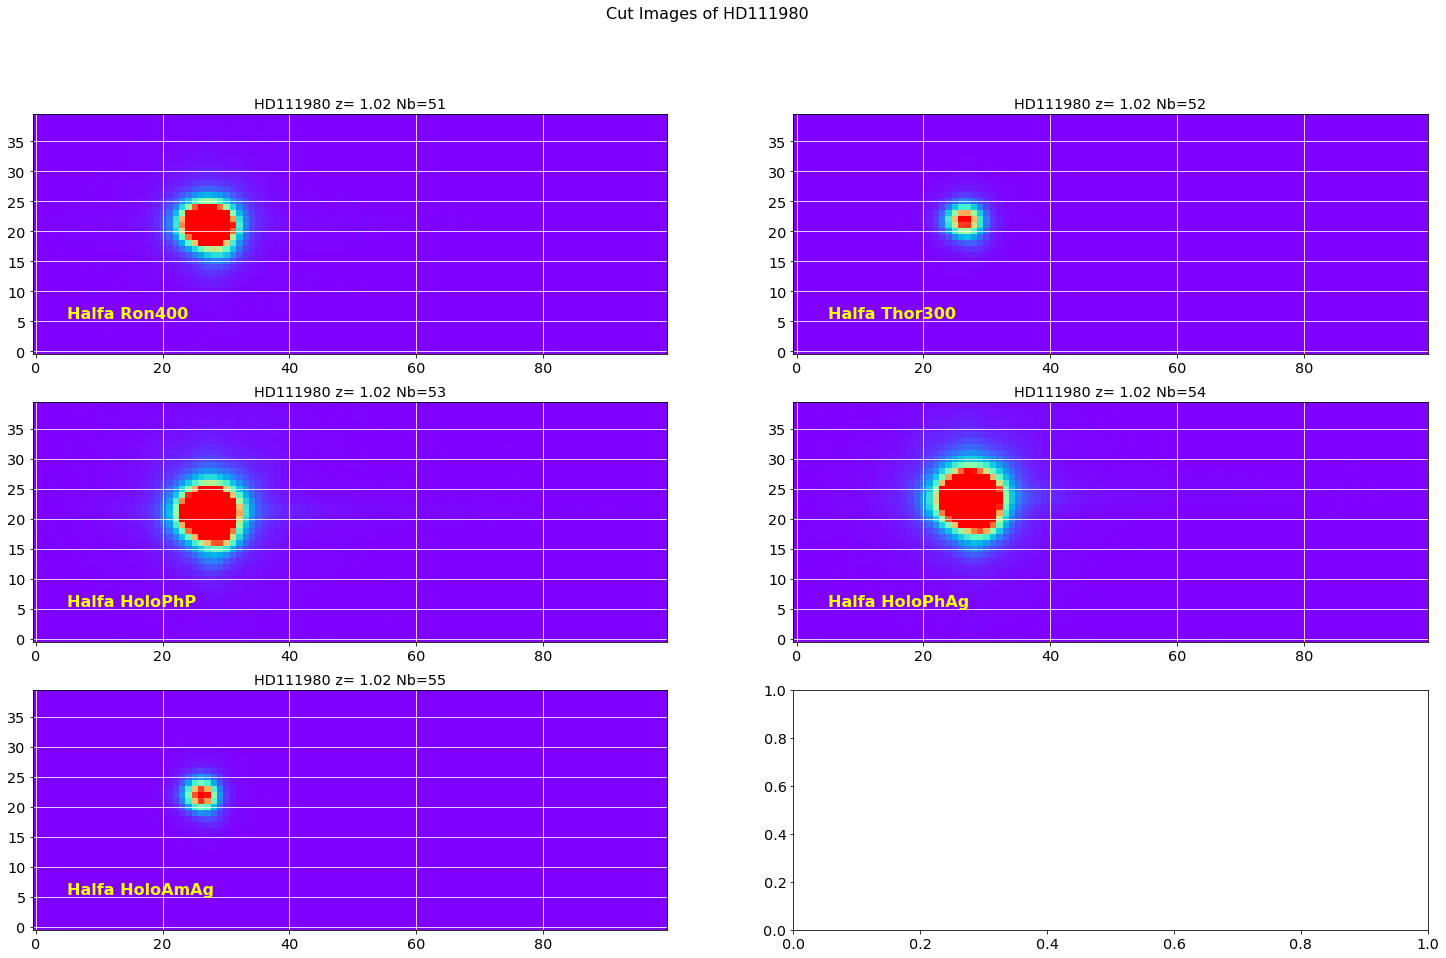

In [29]:
x_guess_rot = DeltaX
y_guess_rot = DeltaY_rot2
DeltaY_rot = [20]*len(all_images)
DeltaX_rot = [50]*len(all_images)

images_cut=ShowCenterImages(x_guess_rot,y_guess_rot,DeltaX_rot,DeltaY_rot,
                    images_cut_rot,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=2000) 

In [32]:
# (JN) valeurs optimisées pour cette étude
img_mean,img_median,img_std,img_sources=ComputeStatImages(images_cut,fwhm=5,threshold=200,sigma=10.0,iters=5)

----------------------------------------------------------------
0  mean, median, std =  18.3527009537 4.0160078153 69.4780863817
 id   xcentroid     ycentroid   ...     peak          flux           mag      
--- ------------- ------------- ... ------------ ------------- ---------------
  1 27.1657855515 20.9985809877 ... 14762.395005 1.47922723482 -0.425087235615
----------------------------------------------------------------
1  mean, median, std =  2.58881477543 0.786373868218 10.9995068063
 id   xcentroid     ycentroid   ...      peak          flux           mag      
--- ------------- ------------- ... ------------- ------------- ---------------
  1 26.5174237337 21.7611280371 ... 2105.56098576 1.32136221437 -0.302554708945
----------------------------------------------------------------
2  mean, median, std =  39.243293035 6.69608954104 150.134669973
 id   xcentroid     ycentroid   ...      peak          flux           mag      
--- ------------- ------------- ... ------------- -

### Central star position

[[ 777.16578555   30.99858099]
 [ 776.51742373   31.76112804]
 [ 777.18068093   30.9596071 ]
 [ 777.49764656   33.2715599 ]
 [ 776.06921809   31.99729027]]


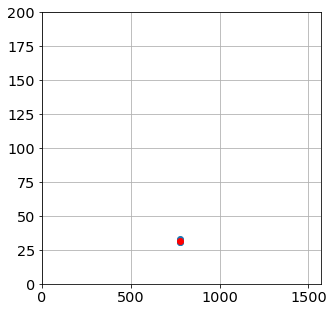

In [33]:
x_star = []
y_star = []
for index,s in enumerate(img_sources):
    for ss in s:
        x_star.append(ss['xcentroid']+x_guess_rot[index]-DeltaX_rot[index])
        y_star.append(ss['ycentroid']+y_guess_rot[index]-DeltaY_rot[index])
        
positions_central = np.array([x_star,y_star]).T
print positions_central

x_mean = np.mean(x_star)
y_mean = np.mean(y_star)
img_size=all_images[0].shape
plt.figure(figsize=(5,5))
plt.plot(x_star,y_star,'o')
plt.plot(x_mean,y_mean,'ro')
plt.xlim(0,img_size[1])
plt.ylim(0,img_size[0])
plt.grid(True)

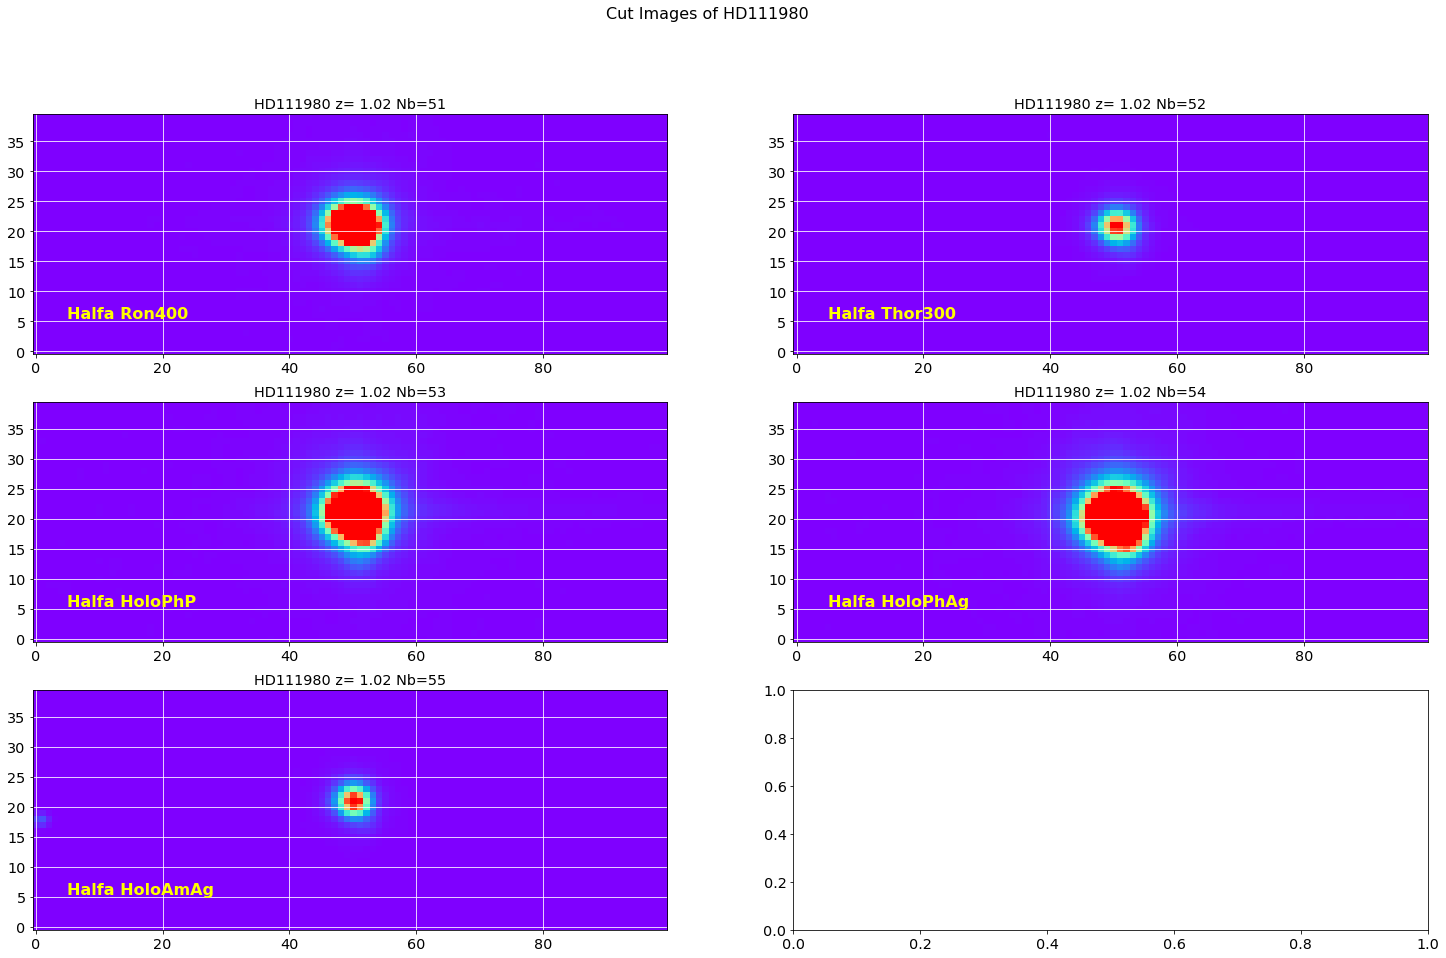

In [35]:
images_cut=ShowCenterImages(x_star,y_star,DeltaX_rot,DeltaY_rot,
                    images_cut_rot,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=2000) 

## Save results

In [36]:
newfullfilenames=[]
for idx,f in np.ndenumerate(sorted_files):
    short_infilename=f.split("/")[2]
    short_partfilename=re.findall('^cutimg_(.*)',short_infilename)
    short_outfilename='rotimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [37]:
for idx,f in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut_rot[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(f,overwrite=True)
textfilename=os.path.join(outputdir,'star_centroids.txt')
print textfilename
np.savetxt(textfilename,positions_central,header="y_star x_star",fmt='%d')

!ls -l rotated_fitsimages

./rotated_fitsimages/star_centroids.txt
total 7528
-rw-r--r--  1 jneveu  staff  766080  8 aoû 14:30 rotimg_20170531_051.fits
-rw-r--r--  1 jneveu  staff  766080  8 aoû 14:30 rotimg_20170531_052.fits
-rw-r--r--  1 jneveu  staff  766080  8 aoû 14:30 rotimg_20170531_053.fits
-rw-r--r--  1 jneveu  staff  766080  8 aoû 14:30 rotimg_20170531_054.fits
-rw-r--r--  1 jneveu  staff  766080  8 aoû 14:30 rotimg_20170531_055.fits
-rw-r--r--  1 jneveu  staff      51  8 aoû 14:30 star_centroids.txt


# Extract spectra
===================================

In [38]:
outputdir="./spectrum_fitsspec"
ensure_dir(outputdir)

inputdir="./rotated_fitsimages"
SelectTagRe='^rotimg_%s_([0-9]+).fits$' % date # regular expression to select the file
SearchTagRe='^rotimg_%s_[0-9]+.fits$' % date

In [39]:
sorted_numbers,sorted_files = MakeFileList([inputdir],MIN_IMGNUMBER,MAX_IMGNUMBER,SelectTagRe,SearchTagRe) 

all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

print 'Number of images:',len(all_images)

Number of images: 5


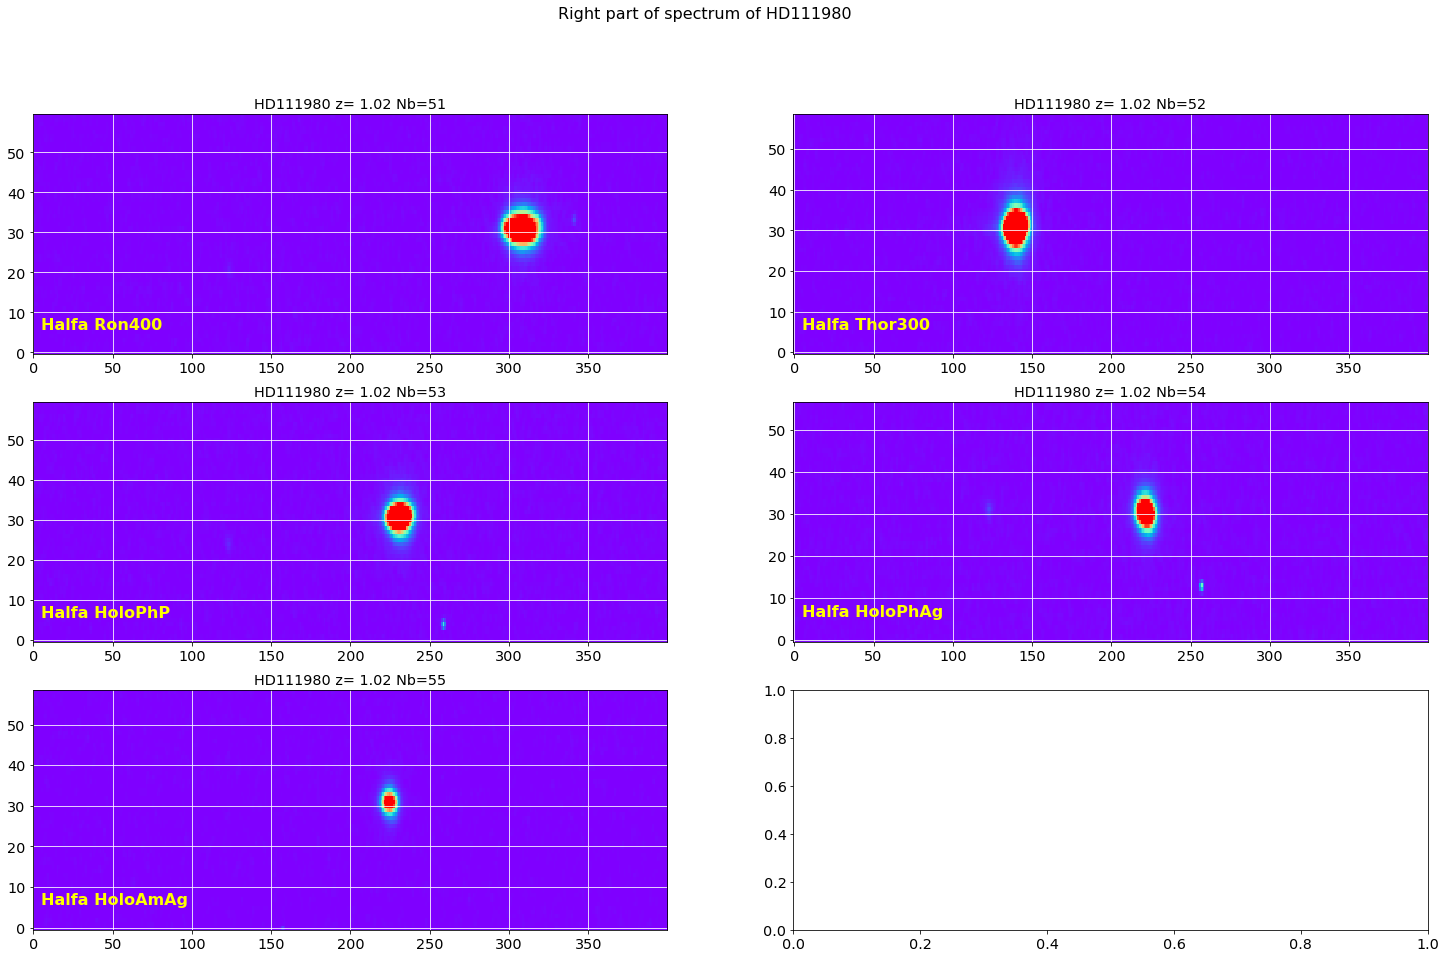

In [41]:
# Right spectrum
ShowCenterImages([1300]*len(all_images),y_star,[200]*len(all_images),[30]*len(all_images),
                 all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=500)
title='Right part of spectrum of {} '.format(object_name)
plt.suptitle(title,size=16)
figfilename=os.path.join(dir_top_images,'rightorder.pdf')
plt.savefig(figfilename)  

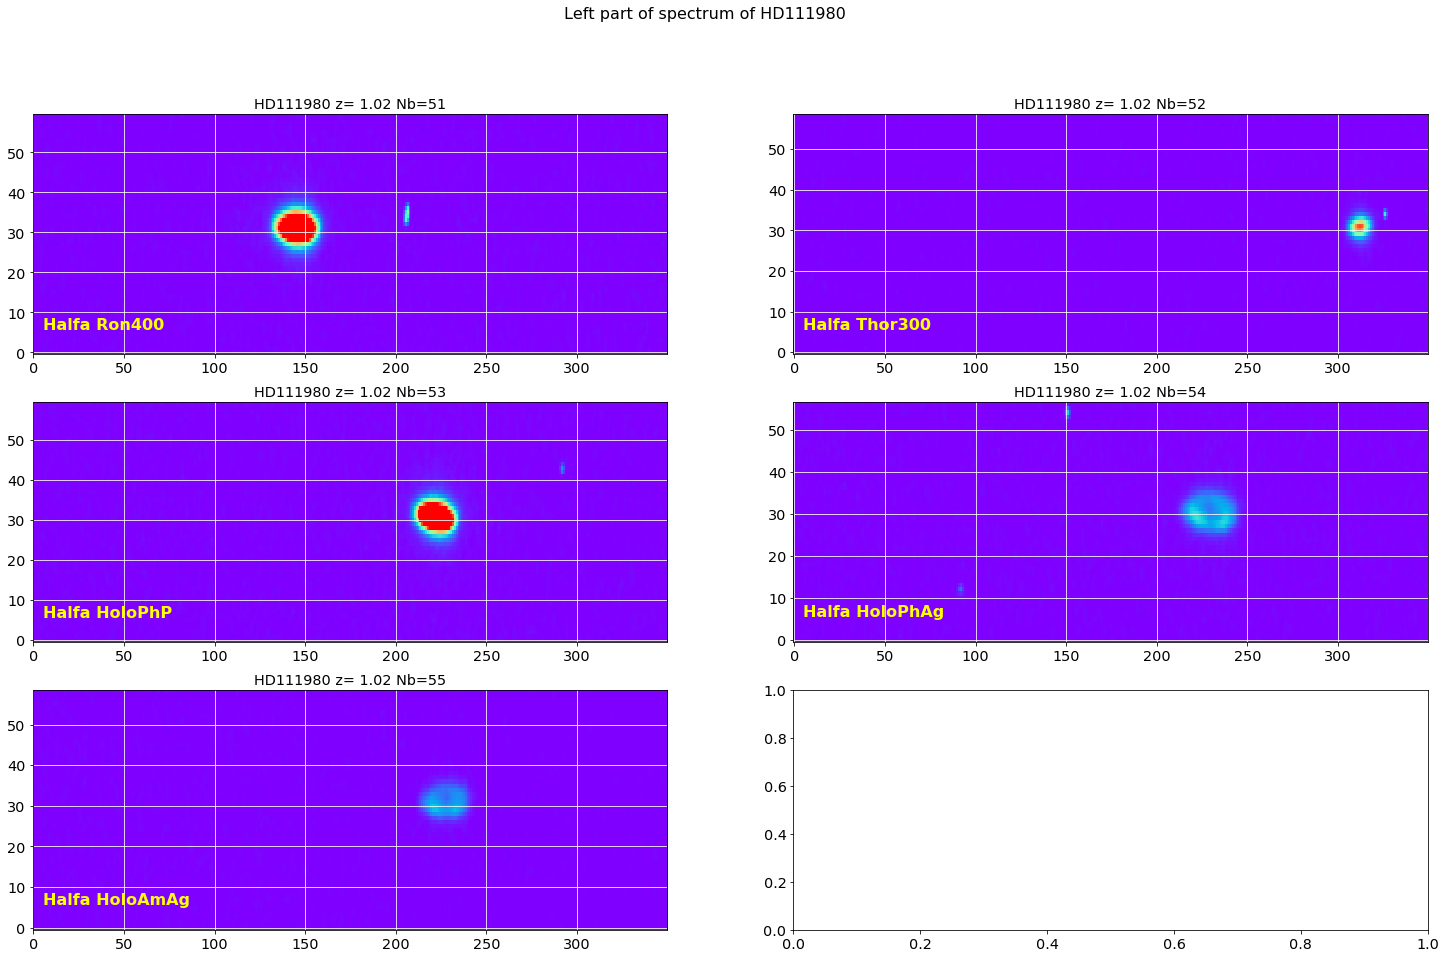

In [42]:
# Left spectrum
ShowCenterImages([150]*len(all_images),y_star,[200]*len(all_images),[30]*len(all_images),
                 all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=500)
title='Left part of spectrum of {} '.format(object_name)
plt.suptitle(title,size=16)
figfilename=os.path.join(dir_top_images,'leftorder.pdf')
plt.savefig(figfilename)  

### Extraction

[31, 32, 31, 33, 32]

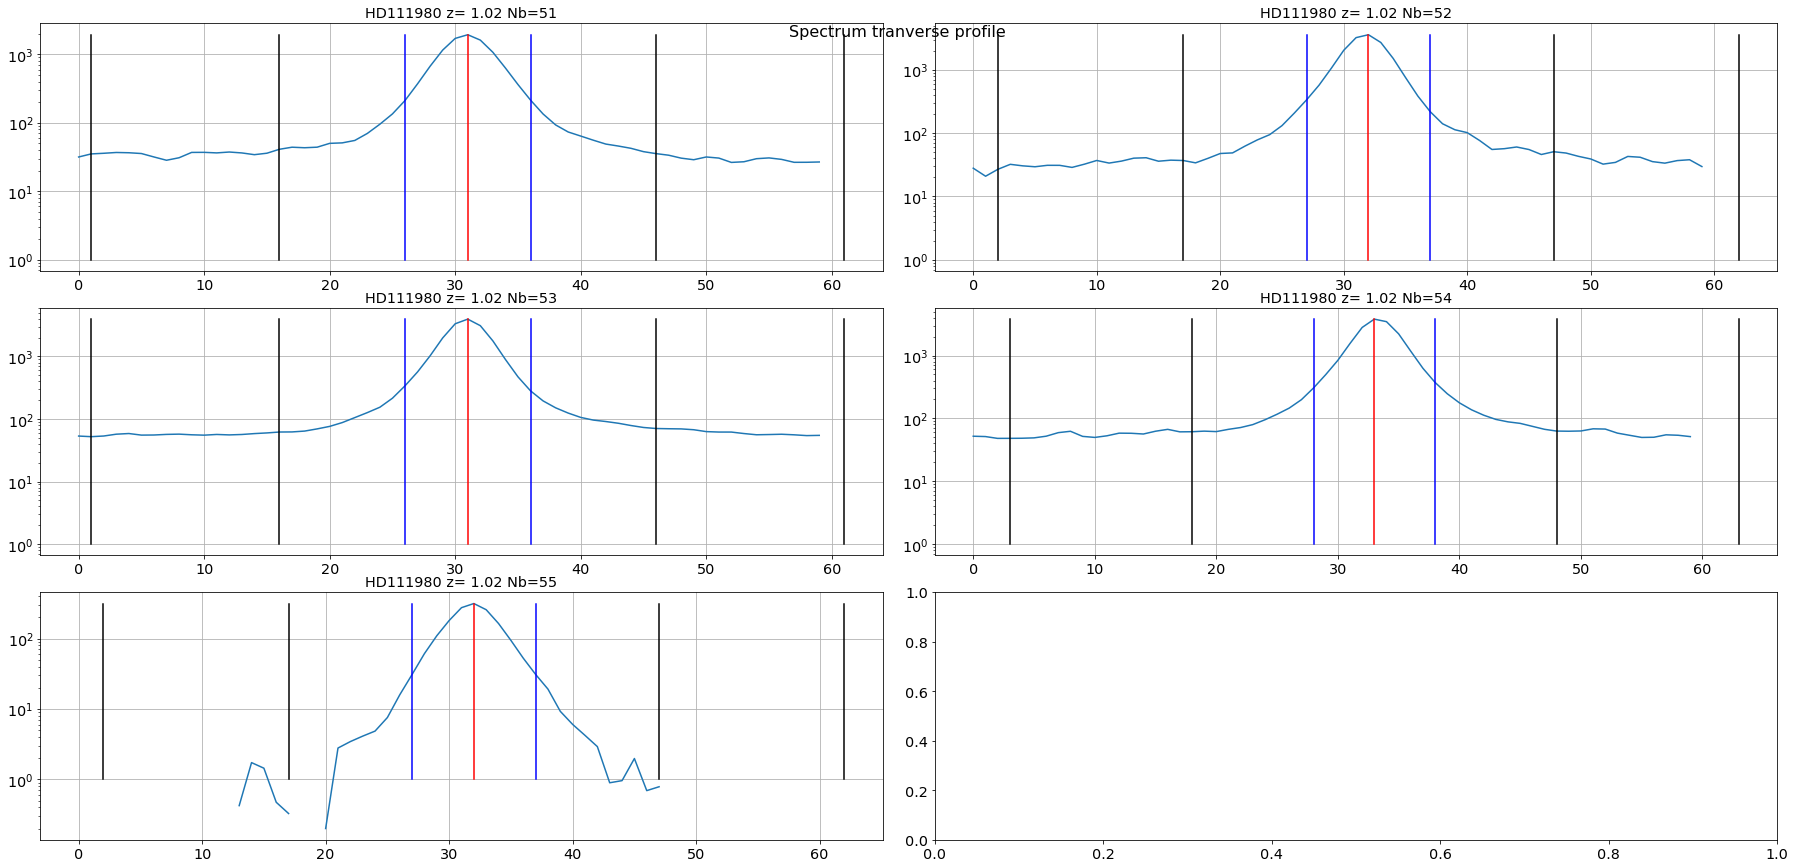

In [48]:
ShowTransverseProfile(all_images,all_titles,object_name,all_expo,NBIMGPERROW=2,DeltaX=1000,w=5,ws=[15,30],right_edge=1800)

In [81]:
thespectra,thespectraUp,thespectraDown=ExtractSpectra(y_star,all_images,all_titles,object_name,all_expo,
                                                      w=5,ws=[10,30],right_edge=1800)

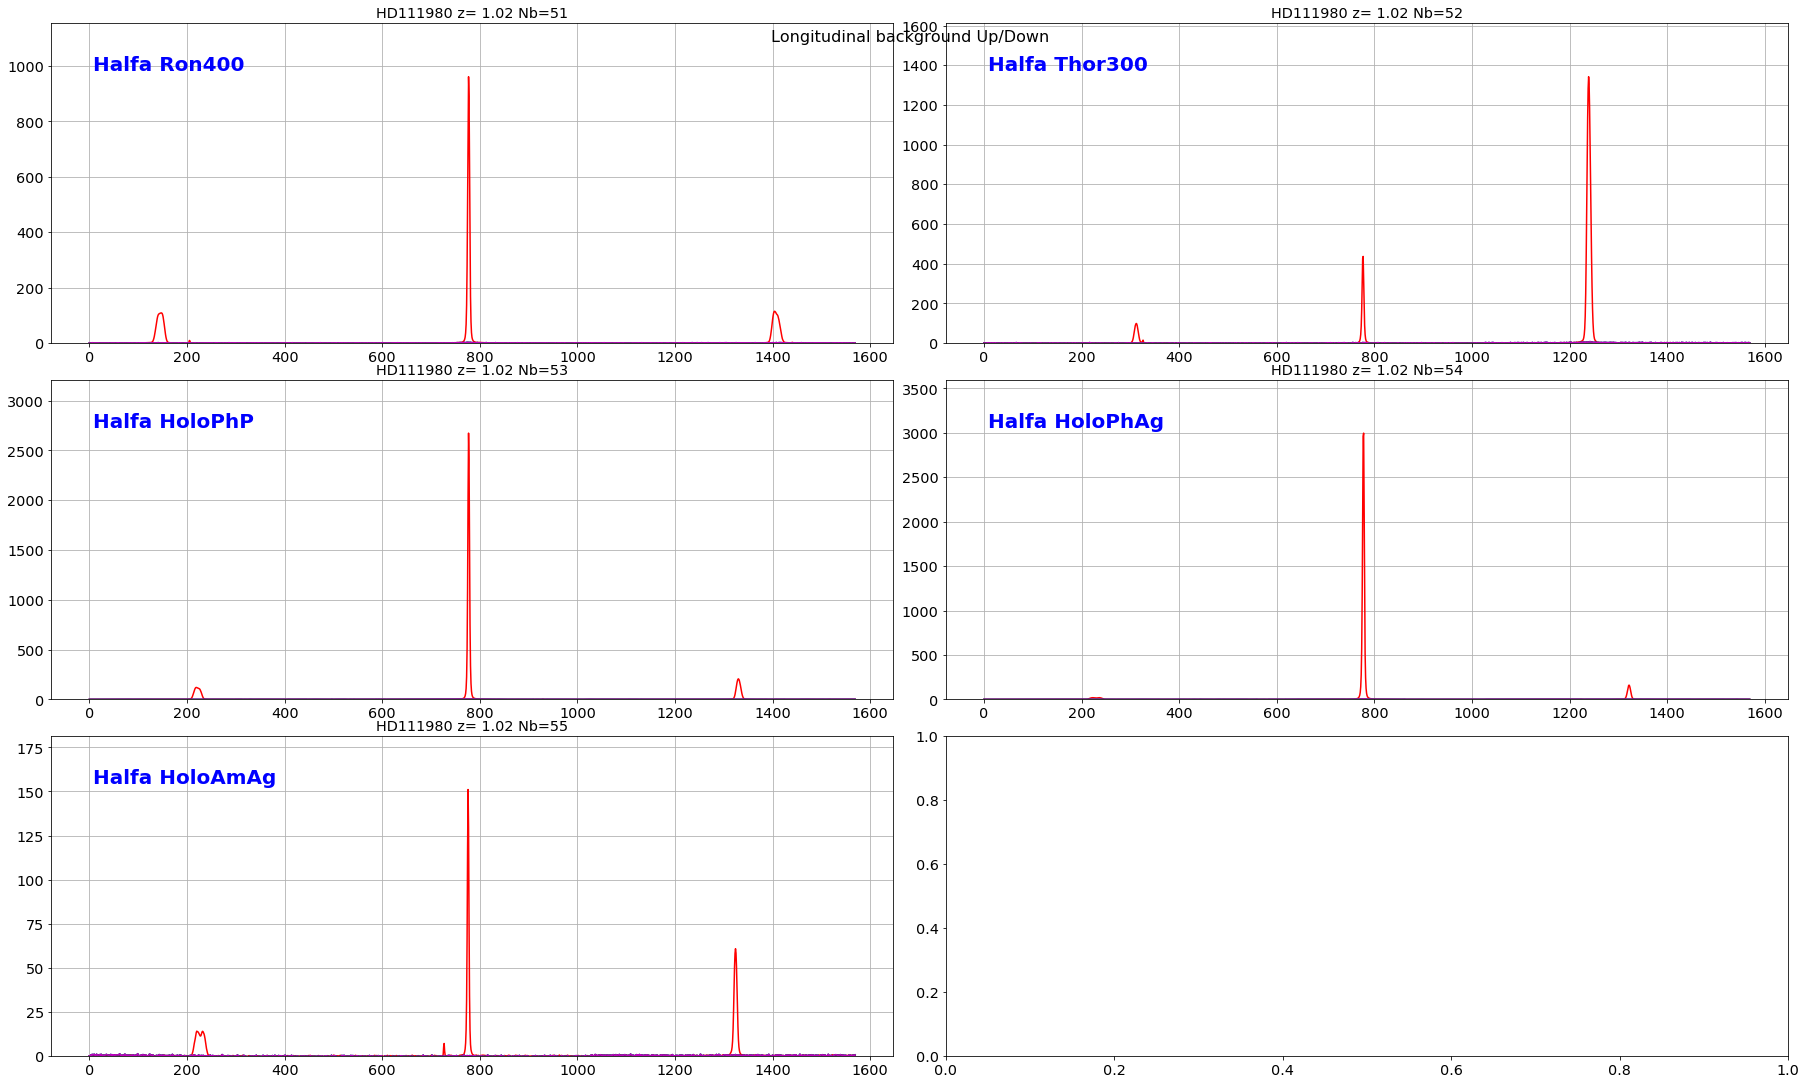

In [82]:
Clean_Up, Clean_Do,Clean_Av=CleanBadPixels(thespectraUp,thespectraDown) 

ShowLongitBackground(thespectra,Clean_Up,Clean_Do,Clean_Av,all_titles,all_filt,object_name,
                     NBIMGPERROW=2,right_edge=1800)
figfilename=os.path.join(dir_top_images,'background_longprofile.pdf')
plt.savefig(figfilename)   

(0, 200.0)

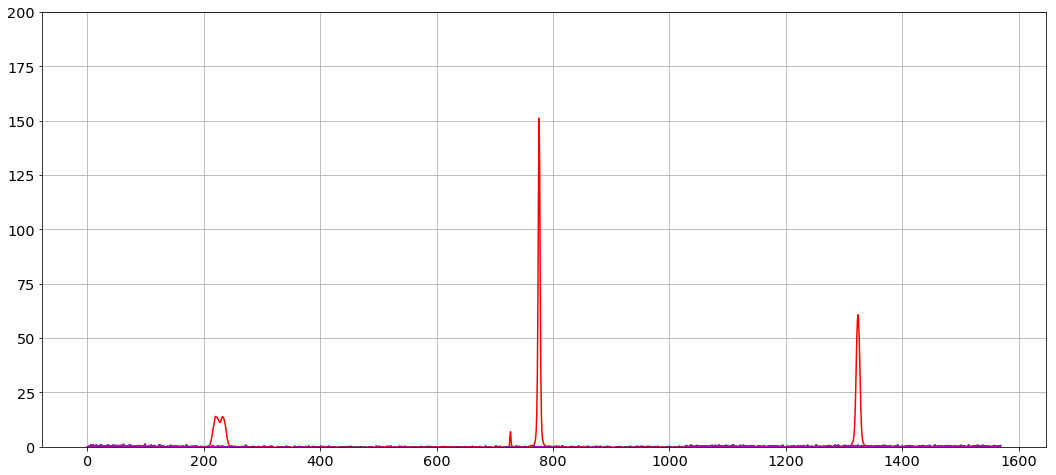

In [83]:
sel=4
plt.figure(figsize=(18,8))
plt.plot(thespectra[sel],'r-') 
plt.plot(Clean_Up[sel],'b-') 
plt.plot(Clean_Do[sel],'g-')
plt.plot(Clean_Av[sel],'m-')
plt.grid(True)
plt.ylim(0,200.)

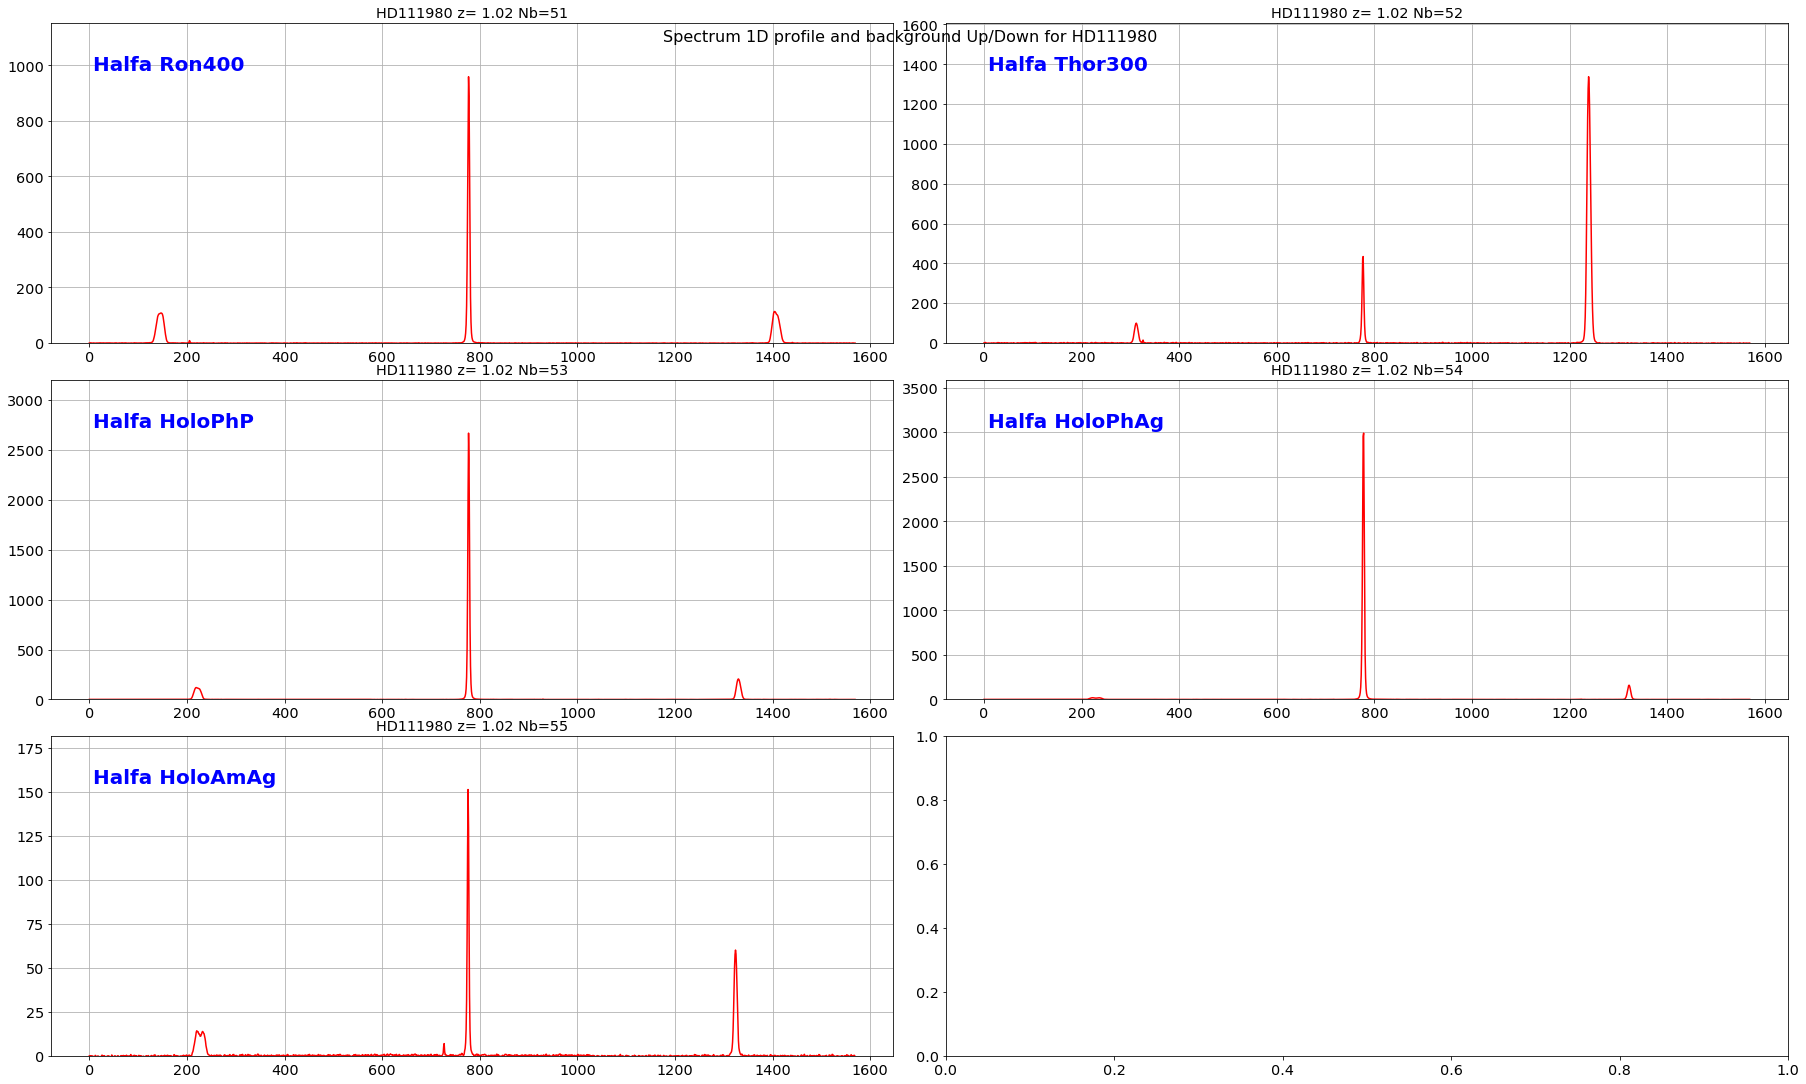

In [84]:
thecorrspectra=CorrectSpectrumFromBackground(thespectra,Clean_Av)

ShowSpectrumProfile(thecorrspectra,all_titles,object_name,all_filt,NBIMGPERROW=2)
figfilename=os.path.join(dir_top_images,'correctedspectrum_profile.pdf')
plt.savefig(figfilename) 

# Grating characterisation

Halfa Ron400:	 gaussian center x=777.19+/-0.02
Halfa Thor300:	 gaussian center x=776.56+/-0.02
Halfa HoloPhP:	 gaussian center x=777.23+/-0.02
Halfa HoloPhAg:	 gaussian center x=777.49+/-0.02
Halfa HoloAmAg:	 gaussian center x=776.09+/-0.02
CCDPROC star centers:
[777.16578555149874, 776.51742373369007, 777.18068092910175, 777.49764655527576, 776.06921808758102]


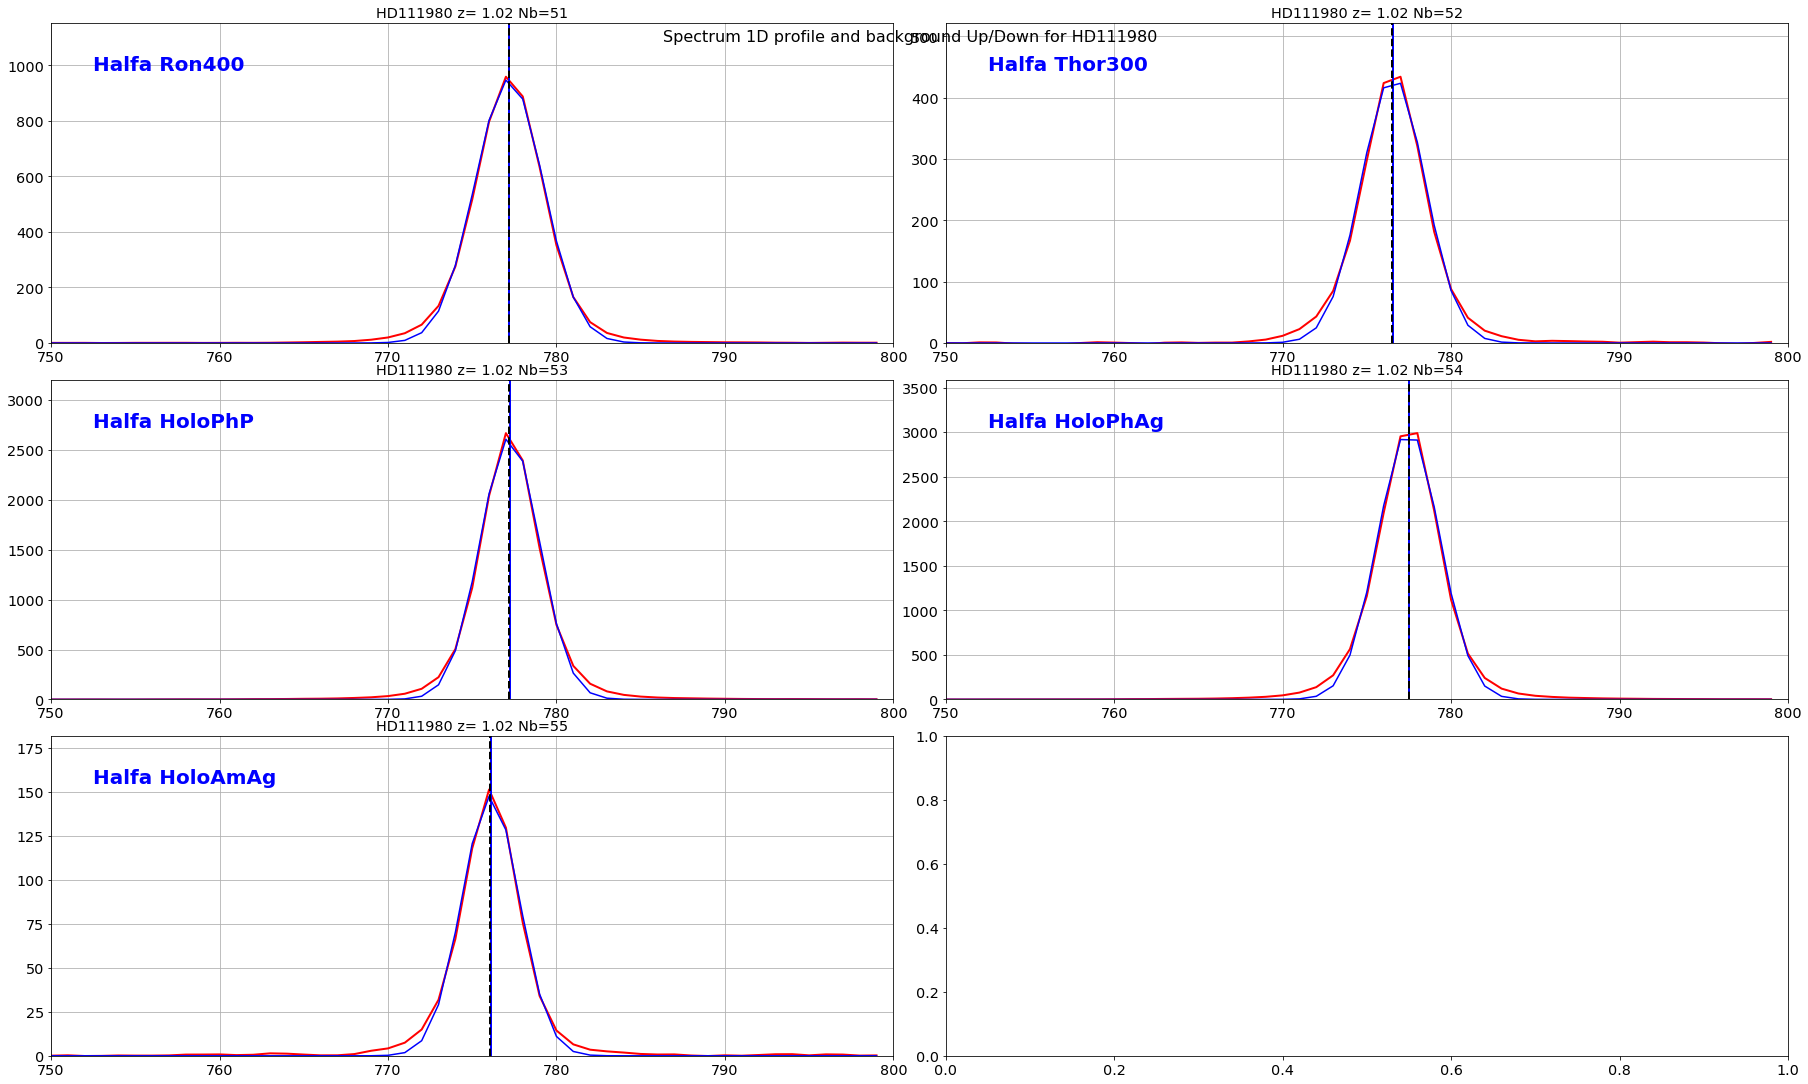

In [85]:
# Zero order profile
ShowSpectrumProfileFit(thecorrspectra,all_titles,object_name,all_filt,NBIMGPERROW=2,
                       xlim=(750,800),guess=[10,800,100],vertical_lines=x_star)
print 'CCDPROC star centers:'
print x_star

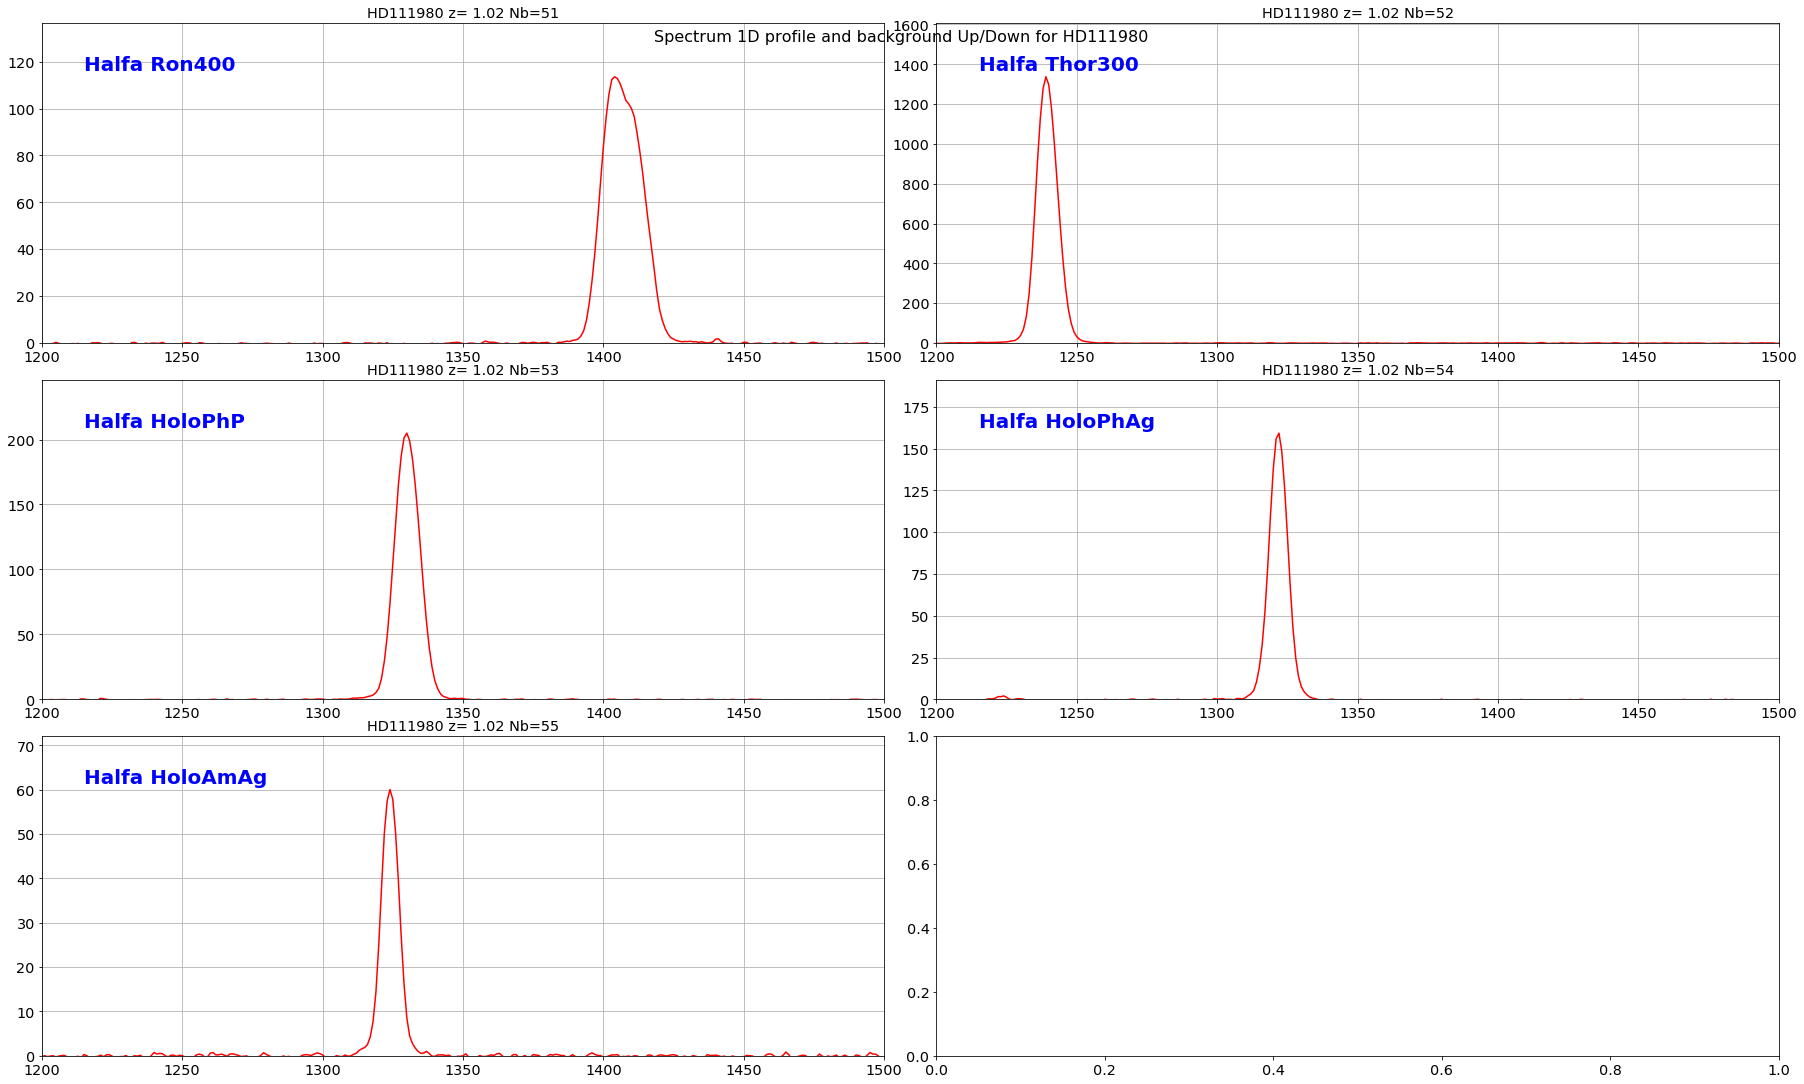

In [86]:
# Right spectrum profile
ShowSpectrumProfile(thecorrspectra,all_titles,object_name,all_filt,NBIMGPERROW=2,xlim=(1200,1500))

Halfa Ron400:	 gaussian center x=1406.65+/-0.06
Halfa Thor300:	 gaussian center x=1239.35+/-0.01
Halfa HoloPhP:	 gaussian center x=1330.13+/-0.01
Halfa HoloPhAg:	 gaussian center x=1321.79+/-0.01
Halfa HoloAmAg:	 gaussian center x=1324.06+/-0.01


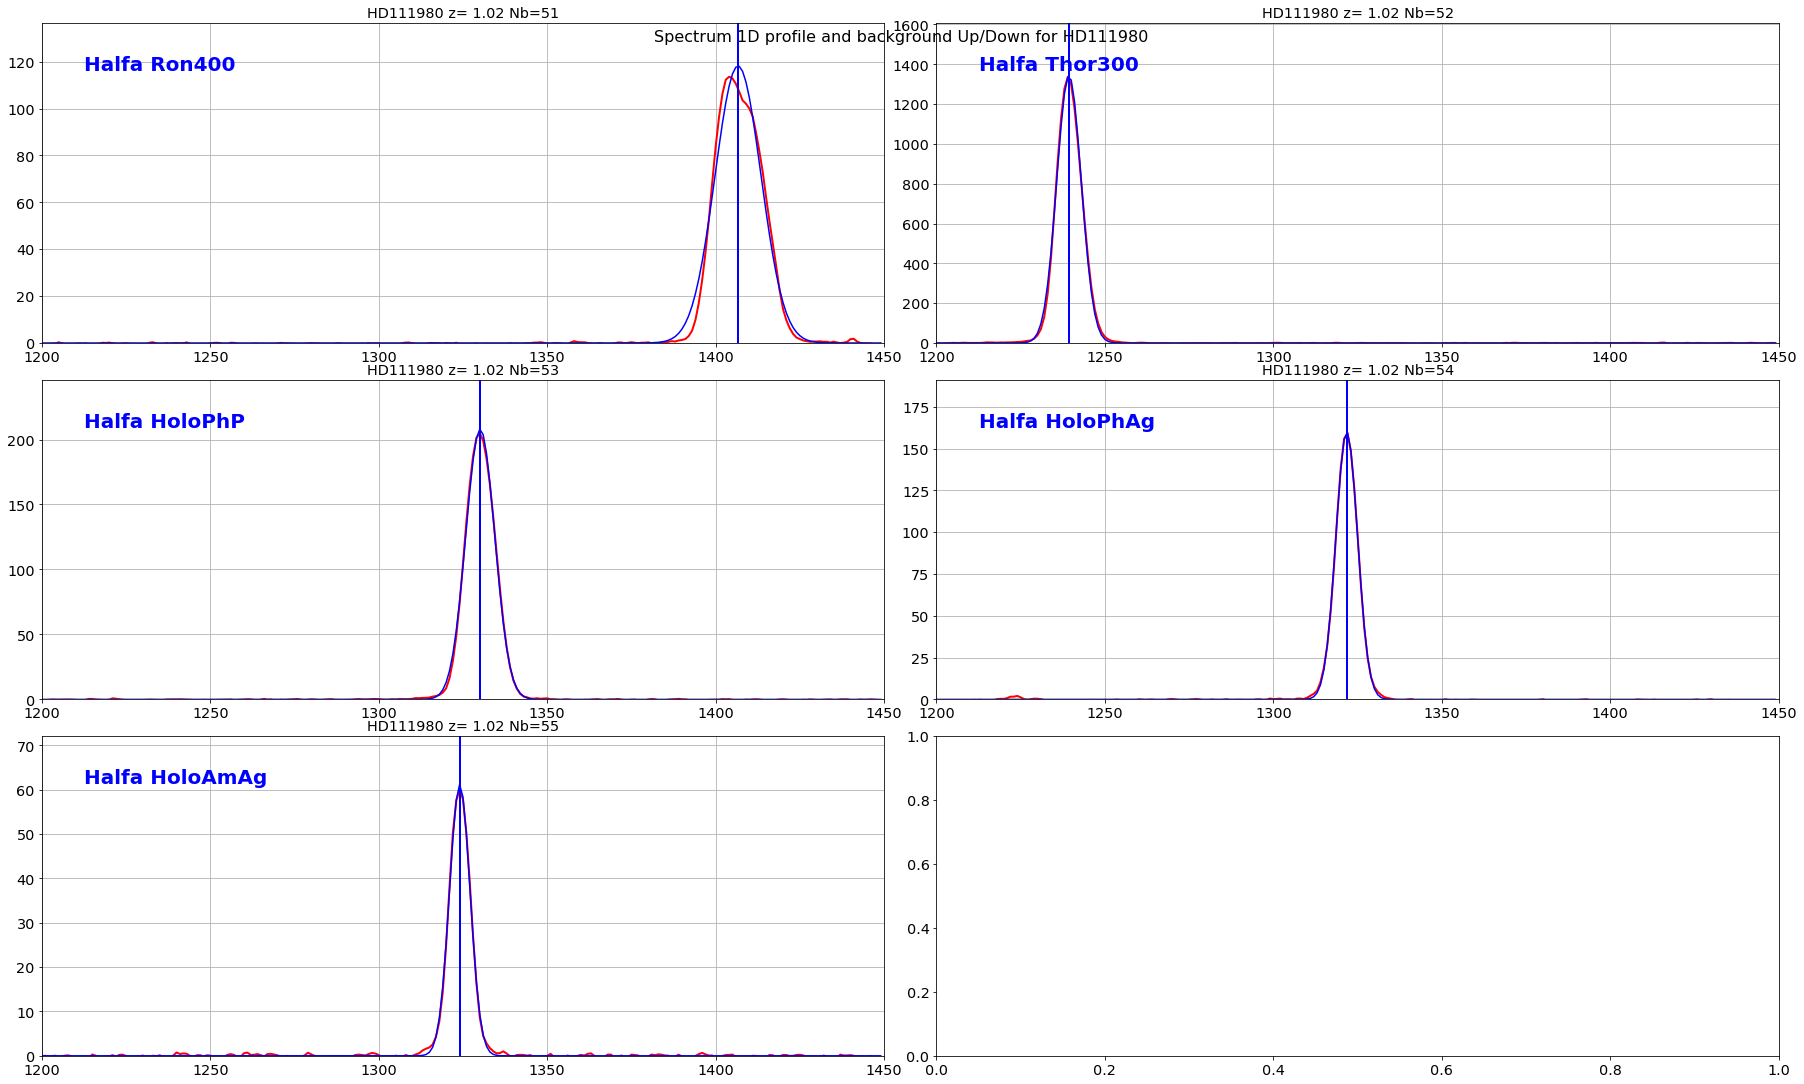

In [87]:
ShowSpectrumProfileFit(thecorrspectra,all_titles,object_name,all_filt,NBIMGPERROW=2,
                            xlim=(1200,1450),guess=[10,1400,50])
figfilename=os.path.join(dir_top_images,'correctedspectrum_rightprofile2.pdf')
plt.savefig(figfilename)  

Halfa Ron400:	 gaussian center x=145.19+/-0.05
Halfa Thor300:	 gaussian center x=312.07+/-0.03
Halfa HoloPhP:	 gaussian center x=221.39+/-0.05
Halfa HoloPhAg:	 gaussian center x=229.17+/-0.19
Halfa HoloAmAg:	 gaussian center x=226.77+/-0.16


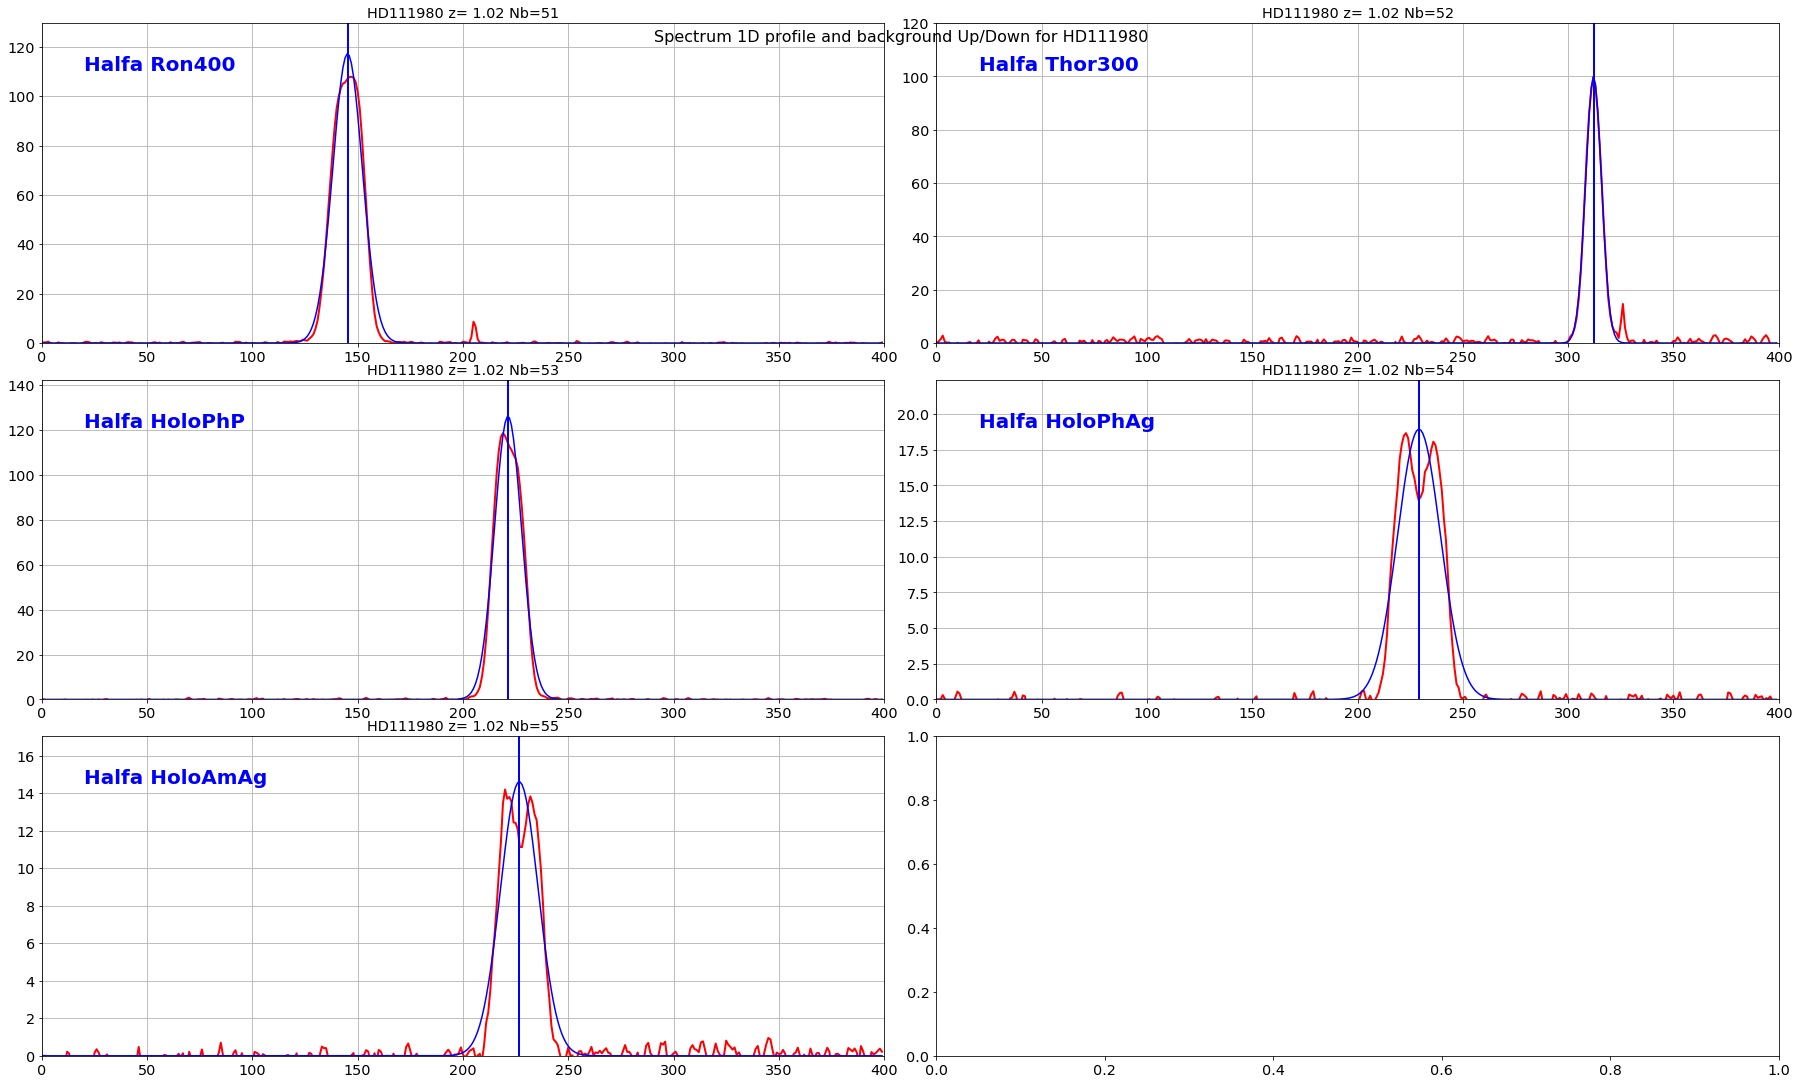

In [88]:
ShowSpectrumProfileFit(thecorrspectra,all_titles,object_name,all_filt,NBIMGPERROW=2,
                            xlim=(0,400),guess=[10,200,100])
figfilename=os.path.join(dir_top_images,'correctedspectrum_leftprofile2.pdf')
plt.savefig(figfilename)  

Present distance to CCD : 55.45 mm (to update if necessary)
-------------------------------
Halfa Ron400
Position of the H-alpha emission line : 629.48 +/- 0.06 pixels (0.01 percent)
Deduced distance to CCD with Halfa Ron400 : 55.56 +/- 0.15 mm (0.27 percent)
-------------------------------
Halfa Thor300
Position of the H-alpha emission line : 462.83 +/- 0.01 pixels (0.00 percent)
Deduced distance to CCD with Halfa Thor300 : 55.34 +/- 0.19 mm (0.35 percent)
-------------------------------
Average distance to CCD : 55.45 +/- 0.17 mm (0.31 percent)


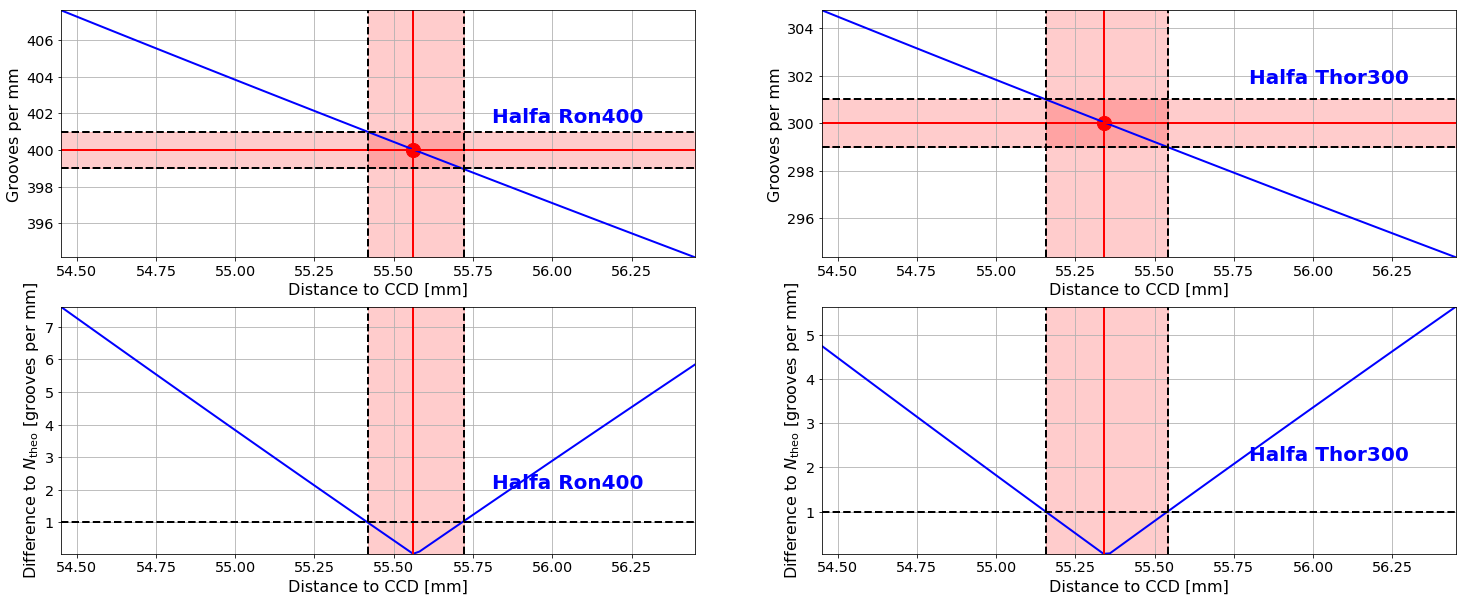

Present distance to CCD : 55.45 mm (to update if necessary)
-------------------------------
Halfa Ron400
Position of the H-alpha emission line : 631.97 +/- 0.05 pixels (0.01 percent)
Deduced distance to CCD with Halfa Ron400 : 55.78 +/- 0.15 mm (0.27 percent)
-------------------------------
Halfa Thor300
Position of the H-alpha emission line : 464.45 +/- 0.03 pixels (0.01 percent)
Deduced distance to CCD with Halfa Thor300 : 55.54 +/- 0.19 mm (0.35 percent)
-------------------------------
Average distance to CCD : 55.66 +/- 0.17 mm (0.31 percent)


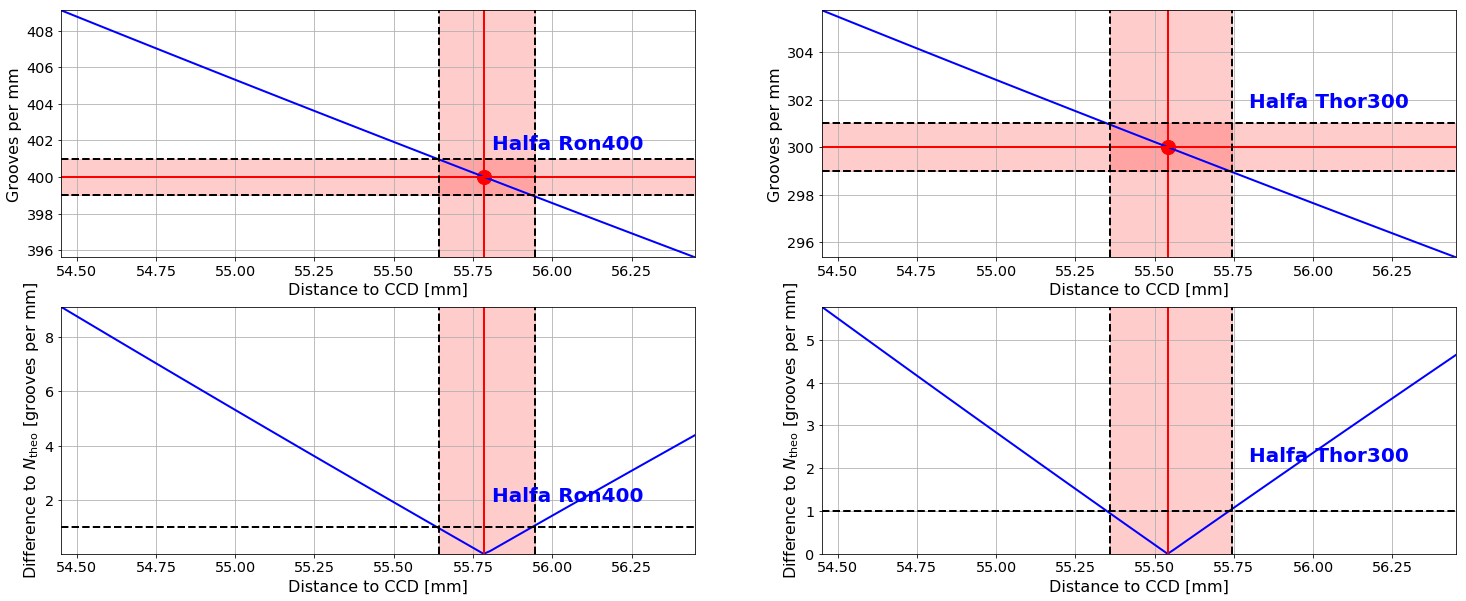

-------------------------------
Average distance to CCD : 55.56 +/- 0.17 mm (0.31 percent)


In [89]:
left_edge = 1200
right_edge = 1500
guess = [10,1400,50]
distance_rightorder, distance_rightorder_err = CalibrateDistance2CCD_OneOrder(thecorrspectra,
                            x_star,all_filt,left_edge,right_edge,guess)

left_edge = 0
right_edge = 400
guess=[10,200,100]
distance_leftorder, distance_leftorder_err = CalibrateDistance2CCD_OneOrder(thecorrspectra,
                            x_star,all_filt,left_edge,right_edge,guess)

print '-------------------------------'  
distance_mean = np.mean([distance_rightorder,distance_leftorder])
distance_mean_err = np.sqrt(np.mean(np.array([distance_rightorder_err,distance_leftorder_err])**2))
print 'Average distance to CCD : %.2f +/- %.2f mm (%.2f percent)' % (distance_mean,distance_mean_err,100*distance_mean_err/distance_mean)

Present distance to CCD : 55.45 mm (to update if necessary)
-------------------------------
Halfa Ron400
Position of the H-alpha emission line : 630.73 +/- 0.04 pixels (0.01 percent)
Deduced distance to CCD with Halfa Ron400 : 55.68 +/- 0.15 mm (0.27 percent)
-------------------------------
Halfa Thor300
Position of the H-alpha emission line : 463.64 +/- 0.02 pixels (0.00 percent)
Deduced distance to CCD with Halfa Thor300 : 55.44 +/- 0.19 mm (0.35 percent)
-------------------------------
Average distance to CCD : 55.56 +/- 0.17 mm (0.31 percent)


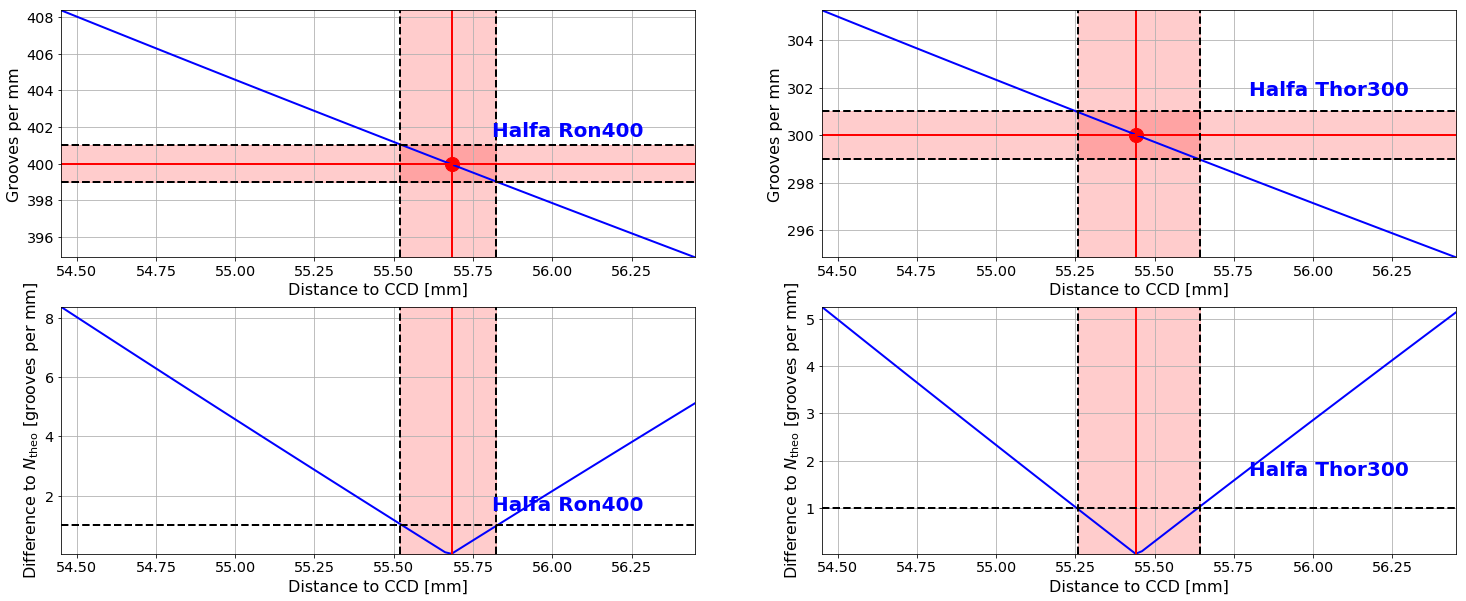

In [90]:
distance_mean, distance_mean_err = CalibrateDistance2CCD_TwoOrder(thecorrspectra,all_filt,
    leftorder_edges=[0,400],rightorder_edges=[1200,1500],guess=[[10,200,200],[10,1400,50]],bounds=(-np.inf,np.inf))

### Conclusion on DISTANCE2CCD

The Thor300 gratings was mounted on the same plastic frame as the holograms, thus the DISTANCE2CCD is expected to closer to the reality for those. The Ron400 H-ampha peaks are unforcused. The Thor300 +1 and -1 orders are well focused then we use the Thor300 TwoOrder method to fix DISTANCE2CCD.

## Resolution of the holograms

With the +1 order

In [91]:
left_edge = 1200
right_edge = 1500
guess = [10,1400,50]
N_rightorder, N_rightorder_err = GratingResolution_OneOrder(thecorrspectra,
                                        x_star,all_images,all_filt,left_edge,right_edge,guess)

H-alpha filter center: 655.9nm 
H-alpha filter width: 6.4nm

Halfa Ron400
N=400.8 +/- 1.3 lines/mm	 H-alpha FWHM=16.0pix with res=0.970nm/pix : FWHM=15.5nm	 ie finesse=71.7
Transverse profile FWHM=6.0pix 
-------------------------------
Halfa Thor300
N=299.5 +/- 1.0 lines/mm	 H-alpha FWHM=8.6pix with res=1.362nm/pix : FWHM=11.7nm	 ie finesse=124.3
Transverse profile FWHM=4.0pix 
-------------------------------
Halfa HoloPhP
N=354.9 +/- 1.2 lines/mm	 H-alpha FWHM=10.1pix with res=1.122nm/pix : FWHM=11.4nm	 ie finesse=132.0
Transverse profile FWHM=4.1pix 
-------------------------------
Halfa HoloPhAg
N=349.6 +/- 1.1 lines/mm	 H-alpha FWHM=7.6pix with res=1.142nm/pix : FWHM=8.7nm	 ie finesse=286.3
Transverse profile FWHM=4.4pix 
-------------------------------
Halfa HoloAmAg
N=351.9 +/- 1.1 lines/mm	 H-alpha FWHM=7.2pix with res=1.133nm/pix : FWHM=8.2nm	 ie finesse=370.7
Transverse profile FWHM=4.1pix 
-------------------------------


With the two orders

In [92]:
Ns, N_errs = GratingResolution_TwoOrder(thecorrspectra,all_images,all_filt,
                        leftorder_edges=[0,400],rightorder_edges=[1200,1500],guess=[[10,200,100],[10,1400,200]])

H-alpha filter center: 655.9nm 
H-alpha filter width: 6.4nm

Halfa Ron400
N=401.5 +/- 1.3 lines/mm
Right order: H-alpha FWHM=16.0pix with res=0.97nm/pix : FWHM=15.5nm	 ie finesse=72.0
Left  order: H-alpha FWHM=16.5pix with res=0.97nm/pix : FWHM=15.9nm	 ie finesse=68.9
Transverse profile FWHM :  6.0pix (right)  6.6pix (left)
-------------------------------
Halfa Thor300
N=300.0 +/- 1.0 lines/mm
Right order: H-alpha FWHM=8.6pix with res=1.4nm/pix : FWHM=11.7nm	 ie finesse=124.9
Left  order: H-alpha FWHM=8.9pix with res=1.4nm/pix : FWHM=12.2nm	 ie finesse=113.9
Transverse profile FWHM :  4.0pix (right)  4.1pix (left)
-------------------------------
Halfa HoloPhP
N=355.7 +/- 1.2 lines/mm
Right order: H-alpha FWHM=10.1pix with res=1.1nm/pix : FWHM=11.3nm	 ie finesse=132.9
Left  order: H-alpha FWHM=15.1pix with res=1.1nm/pix : FWHM=16.9nm	 ie finesse=62.4
Transverse profile FWHM :  4.1pix (right)  5.9pix (left)
-------------------------------
Halfa HoloPhAg
N=350.8 +/- 1.1 lines/mm
Right ord

## Save grating resolutions

The -1 order from the holograms is completely unfocused, thus we use the OneOrder method to set the hologram resolution.

In [93]:
for index in range(len(all_filt)):
    holo_name = all_filt[index].replace('Halfa ','')
    dirname = "../../common_tools/data/"+holo_name
    ensure_dir(dirname)
    print 'Save results in ',dirname
    np.savetxt(dirname+'/N.txt',[N_rightorder[index],N_rightorder_err[index]])

Save results in  ../../common_tools/data/Ron400
Save results in  ../../common_tools/data/Thor300
Save results in  ../../common_tools/data/HoloPhP
Save results in  ../../common_tools/data/HoloPhAg
Save results in  ../../common_tools/data/HoloAmAg


In [94]:
holos = []
for i in range(5):
    print '------------------------------------'
    holos.append(Hologram(all_filt[i].replace('Halfa ','')))

------------------------------------
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.3 degrees
N = 400.78 +/- 1.28 grooves/mm
Hologram center at x0 = 741.0 and y0 = 741.0 with average tilt of -0.3 degrees
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -0.3 degrees
Order  0 position at x0 = 475.9 and y0 = 742.3
Order +1 position at x0 = 1006.1 and y0 = 739.7
Distance between the orders: 530.15 pixels (12.72 mm)
------------------------------------
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.6 degrees
N = 299.47 +/- 0.99 grooves/mm
Hologram center at x0 = 1398.0 and y0 = 1264.0 with average tilt of -0.6 degrees
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -0.6 degrees
Order  0 position at x0 = 1132.9 and y0 = 1266.7
Order +1 position at x0 = 1663.1 and y0 = 1261.3
Distance between the orders: 530.15 pixels (12.72 mm)
------------------------------------
Grating plate center at x0 = 1024.0 and y0

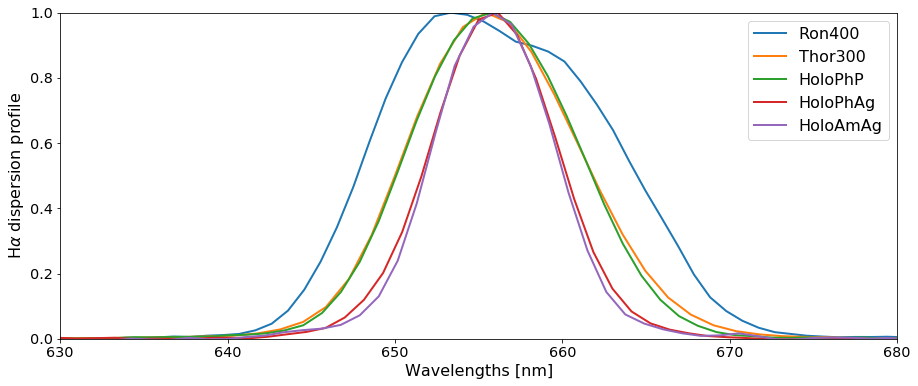

In [95]:
left_edge = 1100
right_edge = 1500

fig, ax = plt.subplots(1,1,figsize=(15,6))
for i in range(5):
    profile = thecorrspectra[i]
    lambdas = holos[i].grating_pixel_to_lambda(np.arange(len(profile)) -x_star[i] ) 
    ax.plot(lambdas,np.array(profile)/np.max(profile[left_edge:right_edge]),label=holos[i].label,lw=2)
#plot_atomic_lines(ax,np.max(profile[1])*1.2,redshift=0,atmospheric_lines=True)
ax.set_xlabel('Wavelengths [nm]',fontsize=16)
ax.set_ylabel('H$\\alpha$ dispersion profile',fontsize=16)
ax.set_ylim([0,1])
ax.set_xlim([630,680])
ax.legend(fontsize=16)
figfilename=os.path.join(dir_top_images,'Halpha_profiles.pdf')
plt.savefig(figfilename, bbox_inches='tight', rasterized=True, dpi=300)  
plt.show()

### Main conclusions

- The distance to CCD has been recalibrated using the two orders from the Thorlabs 300 grating
- The hologram effective grooves per mm number is computed using the right order and is approximately 350+/-1
- FWHMs are better on the +1 order and finesse is better for holograms than gratings. Among holograms HoloPhP is less performant

## Save spectra

In [96]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[2]
    short_partfilename=re.findall('^rotimg_(.*)',short_infilename)
    short_outfilename='finalSpectra_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=thecorrspectra[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,clobber=True)
    
!ls -l spectrum_fitsspec

total 288
-rw-r--r--  1 jneveu  staff  25920  8 aoû 14:44 finalSpectra_20170531_051.fits
-rw-r--r--  1 jneveu  staff  25920  8 aoû 14:44 finalSpectra_20170531_052.fits
-rw-r--r--  1 jneveu  staff  25920  8 aoû 14:44 finalSpectra_20170531_053.fits
-rw-r--r--  1 jneveu  staff  25920  8 aoû 14:44 finalSpectra_20170531_054.fits
-rw-r--r--  1 jneveu  staff  25920  8 aoû 14:44 finalSpectra_20170531_055.fits
-rw-r--r--  1 jneveu  staff     51  8 aoû 10:45 star_centroids.txt
